In this notebook I use astronomical images to train neural network. I start with the case of stars versus galaxies. That should be relatively simple, at least with sufficient signal to noise. 

In [96]:
#standard libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm
import sys
import os
#wcs is incompabible with newest numpy thus below not used 
#from astropy import wcs
#to access astronomical images in fits format
from astropy.io import fits
#torch functions
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
#sklearn helper functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,f1_score, log_loss
#xgboost for comparison
from xgboost import XGBClassifier
#logistic regression for comparison 
from sklearn.linear_model import LogisticRegression


Now loading the data on the classification and other properties of the objects to be classified. 

In [2]:
df=pd.read_csv('Stripe82_1.csv',sep=',')
print(df.columns)

Index(['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun', 'camcol',
       'field', 'specobjid', 'class', 'subclass', 'redshift', 'plate', 'mjd',
       'fiberid'],
      dtype='object')


Now looking on the classes, the targets and their counts. 

In [3]:
print(df['class'].value_counts())

GALAXY    3205
STAR      1735
QSO        355
Name: class, dtype: int64


Making a color (a difference of two magntudes) magnitude diagram. Thiskind of data (there are in total 5 magnitudes) could also be used for classification. 
For now it is ignore since the aim is to use images first. 

(26.0, 12.0)

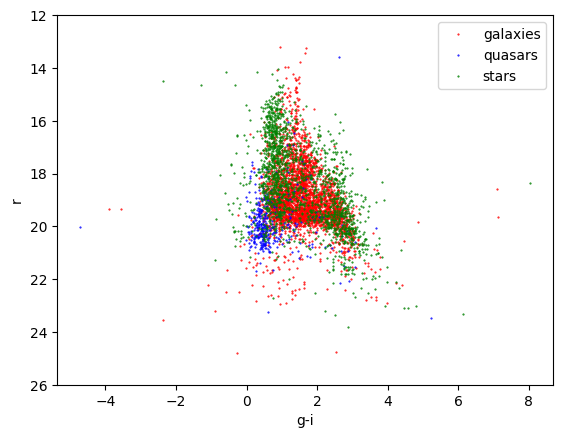

In [4]:
plt.plot(df['g'][df['class']=='GALAXY']-df['i'][df['class']=='GALAXY'],df['r'][df['class']=='GALAXY'],'o',ms=0.5,color='red',label='galaxies') 
plt.plot(df['g'][df['class']=='QSO']-df['i'][df['class']=='QSO'],df['r'][df['class']=='QSO'],'o',ms=0.5,color='blue',label='quasars')
plt.plot(df['g'][df['class']=='STAR']-df['i'][df['class']=='STAR'],df['r'][df['class']=='STAR'],'o',ms=0.5,color='green',label='stars')
plt.legend(loc="best")
plt.xlabel("g-i")
plt.ylabel("r")
plt.ylim(26,12)
#plt.yscale("log")


Now I load an image and to do a first test display of the numeric data.

In [5]:
path='/home/tobias/ml-testing/astr-images/'
hbin=fits.open(path+'f2001_rdeep.fits.gz')
im1=hbin[0].data
#hbin.close()
print(im1)

[[-0.1769429   0.8691173   0.8408659  ... -1.000337   -0.7853276
  -0.45219374]
 [ 0.75963277 -0.4932522   1.3954576  ... -0.41785482 -1.3604484
  -0.5760638 ]
 [ 0.74020797  0.50546163  0.67057353 ...  0.37528276 -0.6279215
  -0.12317654]
 ...
 [ 0.8284947   0.14578946 -0.6937766  ...  1.4887718   2.2809432
   2.2037222 ]
 [ 0.9416072   0.7137203   0.43595394 ...  1.1946634   2.0303423
   2.3305871 ]
 [ 0.57620764 -0.2957804   0.5933519  ...  0.98817205  1.3469133
   2.5567775 ]]


I now built a function which gets the area mcovers by an image. That is used later to find the right image for the targets.

In [6]:
def image_area(dat):
    ra_ref=dat[0].header['CRVAL1']
    ra_center=dat[0].header['CRPIX1']
    ra_scale=dat[0].header['CD1_1']
    dec_ref=dat[0].header['CRVAL2']
    dec_center=dat[0].header['CRPIX2']
    dec_scale=dat[0].header['CD2_2'] 
    image=dat[0].data
    res=np.array([[ra_ref+(1-ra_center)*ra_scale,ra_ref+(image.shape[0]-ra_center)*ra_scale],[dec_ref+(1-dec_center)*dec_scale,dec_ref+(image.shape[1]-dec_center)*dec_scale]])
    return res

Similiarly the function image_par gets the coordinate parameter of an image for this data set.

In [7]:
#assumes that the image pixel coordiantes are perfectly aligned with the skyb coordiates ra and dec
#that is true for this data set but in general another two parameters are needed to specify the miss alignment
def image_par(dat):
    ra_ref=dat[0].header['CRVAL1']
    ra_center=dat[0].header['CRPIX1']
    ra_scale=dat[0].header['CD1_1']
    dec_ref=dat[0].header['CRVAL2']
    dec_center=dat[0].header['CRPIX2']
    dec_scale=dat[0].header['CD2_2'] 
    par=np.array([ra_ref,ra_center,ra_scale,dec_ref,dec_center,dec_scale])
    return par

Below I test the image area function.

In [8]:
res=image_area(hbin)
print(res)

[[50.00036 49.49964]
 [-1.25036 -0.74964]]


Below I build a function which gets the image position of an object whose sky position is known. 
The information on the image can be either obtained from an image or from the opreviously collected image coordinate parameters.

In [9]:
#ra dec position coordinate of object, dat is image inpt, not zero if image==True,
# par is parameter inpu not yero if image==False
def image_xy(ra,dec,dat=0,par=0,image=True):
    #image is used input and the parameters are used
    if image==True:
        ra_ref=dat[0].header['CRVAL1']
        ra_center=dat[0].header['CRPIX1']
        ra_scale=dat[0].header['CD1_1']
        dec_ref=dat[0].header['CRVAL2']
        dec_center=dat[0].header['CRPIX2']
        dec_scale=dat[0].header['CD2_2'] 
    #paramter input    
    else:   
        ra_ref=par[0]
        ra_center=par[1]
        ra_scale=par[2]
        dec_ref=par[3]
        dec_center=par[4]
        dec_scale=par[5]
    #get the positions (pixels on image) 
    # the cosine part is only important if the image not close to the euqator 
    x=ra_center+(ra-ra_ref)/ra_scale*np.cos(dec/180*np.pi)
    y=dec_center+(dec-dec_ref)/dec_scale
    pixels=np.array([x,y])
    return pixels

Test use on image.

In [10]:
pixels=image_xy(49.8,-1,dat=hbin,image=True)
print(f"pixels are {pixels}")

pixels are [1822.52377493 2277.        ]


Now getting all images in a list. 

In [11]:
list_input_files=[f for f in os.listdir(path) 
    if f.endswith('_rdeep.fits.gz') and os.path.isfile(os.path.join(path, f))]
list_input_files.sort()
print(list_input_files)

['f2001_rdeep.fits.gz', 'f2002_rdeep.fits.gz', 'f2003_rdeep.fits.gz', 'f2004_rdeep.fits.gz', 'f2005_rdeep.fits.gz', 'f2011_rdeep.fits.gz', 'f2012_rdeep.fits.gz', 'f2013_rdeep.fits.gz', 'f2014_rdeep.fits.gz', 'f2015_rdeep.fits.gz', 'f2021_rdeep.fits.gz', 'f2022_rdeep.fits.gz', 'f2023_rdeep.fits.gz', 'f2024_rdeep.fits.gz', 'f2025_rdeep.fits.gz', 'f2031_rdeep.fits.gz', 'f2032_rdeep.fits.gz', 'f2033_rdeep.fits.gz', 'f2034_rdeep.fits.gz', 'f2035_rdeep.fits.gz', 'f2041_rdeep.fits.gz', 'f2042_rdeep.fits.gz', 'f2043_rdeep.fits.gz', 'f2044_rdeep.fits.gz', 'f2045_rdeep.fits.gz', 'f2051_rdeep.fits.gz', 'f2052_rdeep.fits.gz', 'f2053_rdeep.fits.gz', 'f2054_rdeep.fits.gz', 'f2055_rdeep.fits.gz', 'f2061_rdeep.fits.gz', 'f2062_rdeep.fits.gz', 'f2063_rdeep.fits.gz', 'f2064_rdeep.fits.gz', 'f2065_rdeep.fits.gz']


Now I get the centers and image parameters for all images.

In [12]:
centers=np.zeros((2,len(list_input_files)))
wcs_par=np.zeros((6,len(list_input_files)))
for i in range(len(list_input_files)):
    print(i)
    #get images
    hbin=fits.open(path+list_input_files[i],memmap=True)
    #get parameters wanted 
    res=image_area(hbin)
    par=image_par(hbin)
    hbin.close()
    centers[0,i]=(res[0,0]+res[0,1])/2  #center is avarage of extension in both dimensions
    centers[1,i]=(res[1,0]+res[1,1])/2
    #parameters to find objects on images
    wcs_par[:,i]=par
print(centers)    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
[[ 4.97500000e+01  4.97500000e+01  4.97500000e+01  4.97500000e+01
   4.97500000e+01  5.02500000e+01  5.02500000e+01  5.02500000e+01
   5.02500000e+01  5.02500000e+01  5.07500000e+01  5.07500000e+01
   5.07500000e+01  5.07500000e+01  5.07500000e+01  5.12500000e+01
   5.12500000e+01  5.12500000e+01  5.12500000e+01  5.12500000e+01
   5.17500000e+01  5.17500000e+01  5.17500000e+01  5.17500000e+01
   5.17500000e+01  5.22500000e+01  5.22500000e+01  5.22500000e+01
   5.22500000e+01  5.22500000e+01  5.27500000e+01  5.27500000e+01
   5.27500000e+01  5.27500000e+01  5.27500000e+01]
 [-1.00000000e+00 -5.00000000e-01 -1.08246745e-15  5.00000000e-01
   1.00000000e+00 -1.00000000e+00 -5.00000000e-01 -1.08246745e-15
   5.00000000e-01  1.00000000e+00 -1.00000000e+00 -5.00000000e-01
  -1.08246745e-15  5.00000000e-01  1.00000000e+00 -1.00000000e+00
  -5.00000000e-01 -1.08246745e-15  5.00000000e-01  1.00000000e

Now I am getting closest image and the pixels positions on them for all objects of the data frame. Further I create a binary classifier based on whether a galaxy or not to start with a  simple binary classification case. I assume thereby that QSOs are like stars which should be at least approximate the case. 

In [13]:
df['galaxy'] = np.where(df['class']== 'GALAXY', True, False)
#Also I add dummy columns which are later filter with the image and the pixels positions on it for all onbjects
df['image']=-1
df['pixel_x']=-1.0
df['pixel_y']=-1.0
print(df.galaxy.value_counts())

True     3205
False    2090
Name: galaxy, dtype: int64


Printing the head to check whether adding the columns worked. 

In [14]:
print(df.head())

                 objid         ra       dec         u         g         r  \
0  1237657586029232289  52.309974 -0.114058  19.39700  18.27151  17.83080   
1  1237657586029297724  52.435195 -0.052648  17.03745  15.54729  14.91894   
2  1237660240851632288  52.459253  0.004838  19.59124  18.45930  17.97956   
3  1237660241388372059  52.165082  0.451840  20.17925  18.58868  17.87951   
4  1237660241388372089  52.225211  0.560895  19.95980  18.16988  17.40830   

          i         z   run  rerun  ...  class  subclass  redshift plate  \
0  17.67991  17.64519  2820    301  ...   STAR        F5  0.000097  2049   
1  14.66624  14.54055  2820    301  ...   STAR        F9  0.000067  2049   
2  17.62496  17.48819  3438    301  ...   STAR        F5  0.000323  2049   
3  17.59933  17.43295  3438    301  ...   STAR        K1  0.000151  2049   
4  17.09896  16.91901  3438    301  ...   STAR        K1  0.000098  2049   

     mjd  fiberid  galaxy  image  pixel_x  pixel_y  
0  53350      438   False  

Below I go over all objects, find the closest image and get then the pixel position of the object.. 

In [15]:
for i in range(df.shape[0]):
    #distances to all images ceneters
    r=np.sqrt((df['ra'][i]-centers[0])**2+(df['dec'][i]-centers[1])**2)
    #id of the image
    df['image'].iloc[i]=np.argmin(r)
    #get pixel coordinates of image 
    coor=image_xy(df['ra'][i],df['dec'][i],par=wcs_par[:,df['image'].iloc[i]],image=False)
    df['pixel_x'].iloc[i]=coor[0]
    df['pixel_y'].iloc[i]=coor[1]
    

/tmp/ipykernel_5645/3953301984.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image'].iloc[i]=np.argmin(r)
/tmp/ipykernel_5645/3953301984.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixel_x'].iloc[i]=coor[0]
/tmp/ipykernel_5645/3953301984.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixel_y'].iloc[i]=coor[1]


Checking whether the columns are now filled with right coordinates. 

In [16]:
print(df.head())

                 objid         ra       dec         u         g         r  \
0  1237657586029232289  52.309974 -0.114058  19.39700  18.27151  17.83080   
1  1237657586029297724  52.435195 -0.052648  17.03745  15.54729  14.91894   
2  1237660240851632288  52.459253  0.004838  19.59124  18.45930  17.97956   
3  1237660241388372059  52.165082  0.451840  20.17925  18.58868  17.87951   
4  1237660241388372089  52.225211  0.560895  19.95980  18.16988  17.40830   

          i         z   run  rerun  ...  class  subclass  redshift plate  \
0  17.67991  17.64519  2820    301  ...   STAR        F5  0.000097  2049   
1  14.66624  14.54055  2820    301  ...   STAR        F9  0.000067  2049   
2  17.62496  17.48819  3438    301  ...   STAR        F5  0.000323  2049   
3  17.59933  17.43295  3438    301  ...   STAR        K1  0.000151  2049   
4  17.09896  16.91901  3438    301  ...   STAR        K1  0.000098  2049   

     mjd  fiberid  galaxy  image      pixel_x      pixel_y  
0  53350      438  

Analyse the new columns content. 

In [17]:
#sorted by value to see which iamges are used
print(df.image.value_counts().sort_index(0))
print(df.pixel_x.describe())
print(df.pixel_y.describe())

5     227
6     181
7     231
8     244
9     190
10    154
11    192
12    245
13    257
14    227
15    149
16    167
17    203
18    153
19    168
20    173
21    238
22    199
23    199
24    195
25    247
26    277
27    279
28    261
29    239
Name: image, dtype: int64
count    5295.000000
mean     2297.375179
std      1304.735601
min         4.991131
25%      1179.141102
50%      2323.782704
75%      3418.760954
max      4549.603869
Name: pixel_x, dtype: float64
count    5295.000000
mean     2253.338893
std      1304.361251
min       -70.538413
25%      1145.468620
50%      2213.411517
75%      3379.435823
max      4637.182527
Name: pixel_y, dtype: float64


/tmp/ipykernel_5645/1114175374.py:2: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only.
  print(df.image.value_counts().sort_index(0))


In [18]:
I now sort the row of the data frame by image, that minizie how often the images need to be loaded. 

SyntaxError: invalid syntax (4235614990.py, line 1)

In [19]:
df=df.sort_values(by='image')
#reset index since the previous row is not wanted 
df=df.reset_index()
print(df.head)

<bound method NDFrame.head of       index                objid         ra       dec         u         g  \
0      2168  1237660239776908025  50.312948 -0.767717  21.92582  21.18044   
1      1286  1237663237128520044  50.432160 -1.103514  21.96684  20.35859   
2      1287  1237663237128520058  50.439437 -1.164617  22.09616  20.93119   
3       592  1237663237128388950  50.162303 -1.235258  22.20764  19.81604   
4       593  1237663237128388967  50.174576 -1.245299  22.56767  20.52426   
...     ...                  ...        ...       ...       ...       ...   
5290   1850  1237660241925243553  52.205533  0.894619  20.34502  19.15812   
5291   1851  1237660241925243604  52.226615  0.989524  21.01873  19.88625   
5292   2121  1237666301630087433  52.100141  0.771115  19.86979  18.74825   
5293   2126  1237666302167024104  52.167572  1.184058  20.93733  20.05359   
5294   5294  1237666302166958580  52.037329  1.219908  22.68021  21.35267   

             r         i         z   run  ...

Now the arrays with the images are collected. For now I collected 11 times 11 pixels. The n umber is odd because it should usually centered on the brightest image. 

In [20]:
delta=5
#collected array
cut_outs=np.zeros((2*delta+1,2*delta+1,df.shape[0]))
#parameter to indicate whether an image exist. 
df['off_image']=False
for i in range(df.shape[0]):
    #image loaded if first image
    if i==0:
        #load file
        hbin=fits.open(path+list_input_files[df.image.iloc[i]])
        #get image, need to be transposed because of difefrent definitions in astronomy and numpy on what is the first axis
        image=hbin[0].data.T
    else:
        #or if new image
        if df.image.iloc[i]!=df.image.iloc[i-1]:
            hbin=fits.open(path+list_input_files[df.image.iloc[i]])
            #need to be transposed because of difefrent definitions in astronomy and numpy on what is the first axis
            image=hbin[0].data.T  
    #gfigure out if within image borders  then cut out image is collected       
    if round(df.pixel_x.iloc[i])>delta and round(df.pixel_x.iloc[i])<image.shape[0]-delta and  round(df.pixel_y.iloc[i])>delta and round(df.pixel_y.iloc[i])<image.shape[1]-delta:
        cut_outs[:,:,i]=image[round(df.pixel_x.iloc[i])-delta:round(df.pixel_x.iloc[i])+delta+1,round(df.pixel_y.iloc[i])-delta:round(df.pixel_y.iloc[i])+delta+1]
    else:
        #if not marker column set to true
        print(f"row {i} is off the image")
        df['off_image'].iloc[i]=True

row 109 is off the image
row 110 is off the image
row 111 is off the image


/tmp/ipykernel_5645/4177535269.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['off_image'].iloc[i]=True


row 939 is off the image
row 982 is off the image
row 993 is off the image
row 994 is off the image
row 1011 is off the image
row 1312 is off the image
row 2063 is off the image
row 2098 is off the image
row 2241 is off the image
row 2655 is off the image
row 2820 is off the image
row 2850 is off the image
row 2870 is off the image
row 2875 is off the image
row 2964 is off the image
row 2993 is off the image
row 3047 is off the image
row 3101 is off the image
row 3724 is off the image
row 3837 is off the image
row 3855 is off the image
row 3912 is off the image
row 3918 is off the image
row 4041 is off the image
row 4209 is off the image
row 4715 is off the image
row 4835 is off the image
row 5077 is off the image
row 5168 is off the image
row 5200 is off the image
row 5211 is off the image
row 5257 is off the image
row 5258 is off the image


Now I check how rows are off the image.

In [21]:
print(df.off_image.value_counts())

False    5259
True       36
Name: off_image, dtype: int64


Not many, thus they can be ignore. Now  display one object of each kind. 

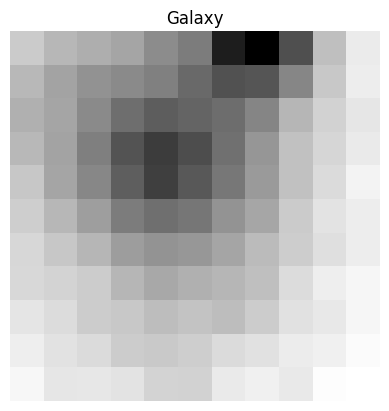

In [22]:
plt.axis('off')
plt.title("Galaxy")
plt.imshow(1-cut_outs[:,:,0].T,cmap=cm.gray, interpolation='nearest')

In [23]:
#finding star and galaxies for display
fs=df['class'][df['class']=='STAR']
print(fs)
fq=df['class'][df['class']=='QSO']
print(fq)

11      STAR
15      STAR
16      STAR
17      STAR
20      STAR
        ... 
5266    STAR
5267    STAR
5269    STAR
5278    STAR
5292    STAR
Name: class, Length: 1735, dtype: object
25      QSO
41      QSO
45      QSO
63      QSO
64      QSO
       ... 
5191    QSO
5242    QSO
5246    QSO
5253    QSO
5288    QSO
Name: class, Length: 355, dtype: object


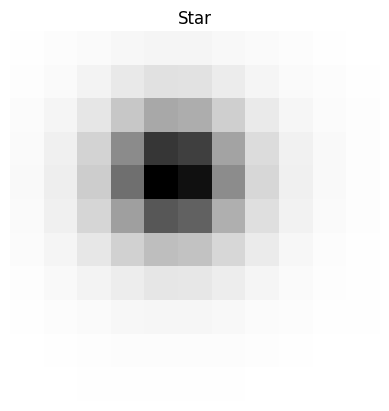

In [24]:
plt.axis('off')
plt.title("Star")
plt.imshow(1-cut_outs[:,:,fs.index[0]].T,cmap=cm.gray, interpolation='nearest')

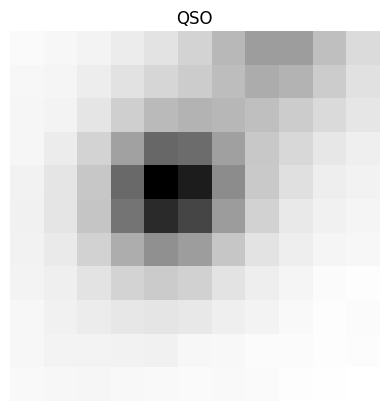

In [25]:
plt.axis('off')
plt.title("QSO")
plt.imshow(1-cut_outs[:,:,fq.index[0]].T,cmap=cm.gray, interpolation='nearest')

As it should be the galaxy is less concentrated than the star and the QSO. It is also visisble that the object are not fully isolated as often the case for images. 

I now drop the objects for which no image could have been found. I also add a forth dimension to the iamge array as needed by pytorch. I could add other colors, but for now I just use one color. The color I use combines the three color with the highest signal to noise to a single. That is useful in astronomy because astronomical images are noisy. 

Because of the noise to I not rescale the cut out images, since rescaling makes that noise is level is very different between different images, while it should be rather similar in this data set.    

In [26]:
#new data frame omitting the object where no image could be found 
df2=df[df.off_image==False]
#new image array, to which also a 4 dimension of zero size is added 
cut_outs2=np.zeros((2*delta+1,2*delta+1,1,df2.shape[0]))
counter=0
for i in range(df.shape[0]):
    if df.off_image.iloc[i]==False:
        #adding the cut outs not of image
        cut_outs2[:,:,0,counter]=cut_outs[:,:,i]
        counter+=1
#Now I add the iamge value to the data frame, that can be used for all connected percitron networks 
x=0
for i in range(cut_outs2.shape[0]):
    for j in range(cut_outs2.shape[1]):
        df2[x]=cut_outs2[i,j,0,:]
        x+=1

/tmp/ipykernel_5645/1758981368.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[x]=cut_outs2[i,j,0,:]
/tmp/ipykernel_5645/1758981368.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[x]=cut_outs2[i,j,0,:]
/tmp/ipykernel_5645/1758981368.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

Printing the head as test as often. 

In [27]:
print(df2.head())

   index                objid         ra       dec         u         g  \
0   2168  1237660239776908025  50.312948 -0.767717  21.92582  21.18044   
1   1286  1237663237128520044  50.432160 -1.103514  21.96684  20.35859   
2   1287  1237663237128520058  50.439437 -1.164617  22.09616  20.93119   
3    592  1237663237128388950  50.162303 -1.235258  22.20764  19.81604   
4    593  1237663237128388967  50.174576 -1.245299  22.56767  20.52426   

          r         i         z   run  ...        111        112        113  \
0  19.97416  19.64367  19.27409  3438  ...   6.554533   7.593651   7.016401   
1  19.48765  19.06683  18.82782  4136  ...   5.149033   5.307359   6.223897   
2  19.48183  18.93008  18.48824  4136  ...  11.629539  13.926988  10.528815   
3  18.69533  18.23049  17.89898  4136  ...   6.260189   7.919204  12.064778   
4  19.25002  18.78460  18.39242  4136  ...   2.556708   3.418560   5.017884   

         114        115        116        117        118        119        120  

Now the data is mostly prepared besides some libraries specifices. 



First I do basic setup tasks relevant for for all torch networks. For now that these are two, firstly a fully connected multilayer network as perceptron. Secondly, a network which uses twodiemnsionalk convolutional layer whoch should be optimized for images. 

First adding the cpu. 

In [28]:
#adding cpu
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")



Using cpu device


In [29]:
#need to be transposed to get into torch format of batch, channels, x, y
#splitting, feature_mlp, targets, feature_images, df properties
feature_train,feature_test,target_train, target_test,image_train,image_test,df_train,df_test= train_test_split(df2.loc[:,0:120],df2.loc[:,"galaxy"],cut_outs2.T,df2,train_size=0.70, shuffle=True, random_state=1)
print("shape of image train data")
print(image_train.shape)

shape of image train data
(3681, 1, 11, 11)


Now I change the target data type to numpy array where that is not yet the case. 

In [30]:
 
feature_train, target_train = np.array(feature_train), np.array(target_train)
feature_test, target_test = np.array(feature_test), np.array(target_test)
print(type(target_train),type(image_test))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


Now I create a class which creates the classification data sets as needed for torch. 

In [31]:
class ClassificationDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

Now I create the data sets as needed for both neural network types. 

In [32]:
train_dataset = ClassificationDataset(torch.from_numpy(feature_train).float(), torch.from_numpy(target_train).float())
test_dataset = ClassificationDataset(torch.from_numpy(feature_test).float(), torch.from_numpy(target_test).float())
train_im_dataset = ClassificationDataset(torch.from_numpy(image_train).float(), torch.from_numpy(target_train).float())
test_im_dataset = ClassificationDataset(torch.from_numpy(image_test).float(), torch.from_numpy(target_test).float())
#print type as test 
print(type(torch.from_numpy(image_test).float()))
print(type(test_im_dataset))


<class 'torch.Tensor'>
<class '__main__.ClassificationDataset'>


Now create the class of the perceptron layer. 

In [33]:
#now 3 layers 
#two options only 
class BinaryClassification3(nn.Module):
    def __init__(self, num_features):
        super(BinaryClassification3, self).__init__()
        self.fc1 = nn.Linear(num_features, 60)
        self.fc2 = nn.Linear(60, 20)  
        self.fc3 = nn.Linear(20, 8)        
        self.fc4 = nn.Linear(8, 1)   
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return (x)

Now I define the parameters needed. 

In [34]:
EPOCHS = 200
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_FEATURES = 121
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_pred = DataLoader(dataset=train_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

Finally I define the model plus the final parameters. 

In [35]:
model =BinaryClassification3(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
#in loss_stats the statistic is collected 
loss_stats = {
    'train': [], 'test': []
}


BinaryClassification3(
  (fc1): Linear(in_features=121, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=8, bias=True)
  (fc4): Linear(in_features=8, out_features=1, bias=True)
)


Now I run the fit. 

In [36]:

print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        test_epoch_loss = 0
        
        model.eval()
        for X_test_batch, y_test_batch in test_loader:
            X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            
            y_test_pred = model(X_test_batch)
                        
            test_loss = criterion(y_test_pred, y_test_batch.unsqueeze(1))
            
            test_epoch_loss += test_loss.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['test'].append(test_epoch_loss/len(test_loader))                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Test Loss: {test_epoch_loss/len(test_loader):.5f}')

Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.55343 | Test Loss: 0.41386
Epoch 002: | Train Loss: 0.54726 | Test Loss: 0.60739
Epoch 003: | Train Loss: 0.49314 | Test Loss: 0.40605
Epoch 004: | Train Loss: 0.52432 | Test Loss: 0.33492
Epoch 005: | Train Loss: 0.45765 | Test Loss: 0.58834
Epoch 006: | Train Loss: 0.39779 | Test Loss: 0.28156
Epoch 007: | Train Loss: 0.44338 | Test Loss: 0.15773
Epoch 008: | Train Loss: 0.41021 | Test Loss: 0.16864
Epoch 009: | Train Loss: 0.42071 | Test Loss: 0.27118
Epoch 010: | Train Loss: 0.34988 | Test Loss: 0.31203
Epoch 011: | Train Loss: 0.33148 | Test Loss: 0.33349
Epoch 012: | Train Loss: 0.30126 | Test Loss: 0.20747
Epoch 013: | Train Loss: 0.29589 | Test Loss: 0.19992
Epoch 014: | Train Loss: 0.35373 | Test Loss: 0.23166
Epoch 015: | Train Loss: 0.32206 | Test Loss: 0.33754
Epoch 016: | Train Loss: 0.29559 | Test Loss: 0.15732
Epoch 017: | Train Loss: 0.29032 | Test Loss: 0.46749
Epoch 018: | Train Loss: 0.24699 | Test Loss: 0.14673
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.15963 | Test Loss: 0.41196
Epoch 154: | Train Loss: 0.15941 | Test Loss: 0.48418
Epoch 155: | Train Loss: 0.15624 | Test Loss: 0.40988
Epoch 156: | Train Loss: 0.15109 | Test Loss: 0.54759
Epoch 157: | Train Loss: 0.17459 | Test Loss: 0.54238
Epoch 158: | Train Loss: 0.17383 | Test Loss: 0.35909
Epoch 159: | Train Loss: 0.17041 | Test Loss: 0.34178
Epoch 160: | Train Loss: 0.16002 | Test Loss: 0.35531
Epoch 161: | Train Loss: 0.16508 | Test Loss: 0.38341
Epoch 162: | Train Loss: 0.15854 | Test Loss: 0.43156
Epoch 163: | Train Loss: 0.15560 | Test Loss: 0.33759
Epoch 164: | Train Loss: 0.15544 | Test Loss: 0.42251
Epoch 165: | Train Loss: 0.15099 | Test Loss: 0.40323
Epoch 166: | Train Loss: 0.18492 | Test Loss: 0.39828
Epoch 167: | Train Loss: 0.16718 | Test Loss: 0.42969
Epoch 168: | Train Loss: 0.17386 | Test Loss: 0.43404
Epoch 169: | Train Loss: 0.21756 | Test Loss: 0.39873
Epoch 170: | Train Loss: 0.16760 | Test Loss: 0.36853
Epoch 171: | Train Loss: 0.2

Now I define a function which predicts the values (probablities) for all samples. 

In [37]:
def pred_torch(model,data):
    y_pred_list_c = []
    with torch.no_grad():
        model.eval()
        for X_batch, _ in data:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_pred_list_c.append(y_test_pred.cpu().numpy())
    y_pred_list_c = [a.squeeze().tolist() for a in y_pred_list_c]
    return y_pred_list_c  

That is then applied on all data. 

In [38]:
m_test=pred_torch(model,test_loader)
m_train=pred_torch(model,train_loader_pred)

I now plot the loss against the epoch. 

Text(0, 0.5, 'BCE loss')

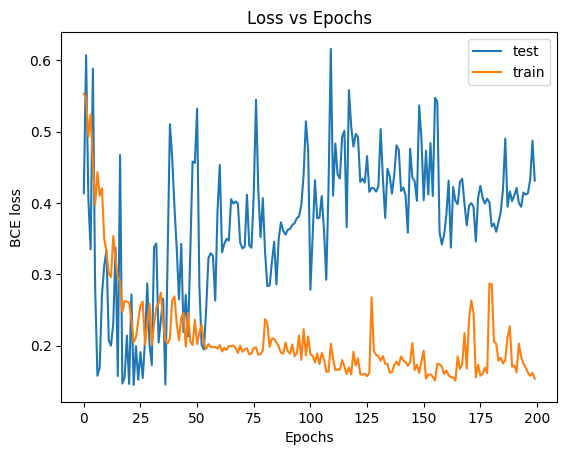

In [39]:

plt.plot(loss_stats['test'],label='test')
plt.plot(loss_stats['train'],label='train')
plt.legend(loc="best")
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BCE loss')

There is likely overfitting, at least the loss of test improves less at the end.

Now I am building a first convolutional network. First loading the data again.  

In [40]:
train_im_loader = DataLoader(dataset=train_im_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_im_loader = DataLoader(dataset=test_im_dataset, batch_size=1)
train_im_loader_pred = DataLoader(dataset=train_im_dataset, batch_size=1)

Below is a not changed neural network copied from somewhere. 

In [41]:
# Implementation of CNN/ConvNet Model  image 28 *28 size not changed  
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # L1 ImgIn shape=(?, 28, 28, 1)
        # Conv -> (?, 28, 28, 32)
        # Pool -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L2 ImgIn shape=(?, 14, 14, 32)
        # Conv      ->(?, 14, 14, 64)
        # Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 62, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L3 ImgIn shape=(?, 7, 7, 64)
        # Conv ->(?, 7, 7, 128)
        # Pool ->(?, 4, 4, 128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            torch.nn.Dropout(p=1 - keep_prob))

        # L4 FC 4x4x128 inputs -> 625 outputs
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - keep_prob))
        # L5 Final FC 625 inputs -> 10 outputs
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = self.fc2(out)
        return out

Below I check how input and output depends on each other to make no mistakes in  it.

In [42]:
input0 = torch.randn(1, 1, 11, 11)
b=torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0)
output0=b(input0)
print(f"first conv layer input: {input0.shape} output: {output0.shape}")

m = nn.MaxPool2d((2, 2), stride=(2, 2))
#standard drops but can be changed, can also use pooling and co get better number 
output = m(output0)
print(f"max pool input:{output0.shape} input:{output.shape}")
#input format (Batch, Number Channels, height, width)
b2=torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)
input2 = torch.randn(1, 16, 4, 4)
output2=b2(input2)
print(f"second conv layer input: {input2.shape} output: {output2.shape}")
output3 = m(output2)
print(f"second max pool layer input: {output2.shape} output: {output3.shape}")

first conv layer input: torch.Size([1, 1, 11, 11]) output: torch.Size([1, 16, 9, 9])
max pool input:torch.Size([1, 16, 9, 9]) input:torch.Size([1, 16, 4, 4])
second conv layer input: torch.Size([1, 16, 4, 4]) output: torch.Size([1, 32, 2, 2])
second max pool layer input: torch.Size([1, 32, 2, 2]) output: torch.Size([1, 32, 1, 1])


Now I build the network. 

In [43]:
class CNNBinary3(torch.nn.Module):
    #no padding because image does not really end when the data ends. 
    def __init__(self):
        super(CNNBinary3, self).__init__()
        # L1 ImgIn shape=(?, 11, 11, 1)
        # Conv -> (?, 9, 9, 12)
        # Pool -> (?, 4, 4, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L2 ImgIn shape=(?, 4, 4, 32)
        # Conv      ->(?, 2, 2, 32)
        # Pool      ->(?, 1, 1, 32)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L3 FC 1x1x32 inputs -> 16 outputs
        self.fc1 = torch.nn.Linear(1 * 1 * 32, 64, bias=True)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        self.layer3 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - keep_prob))
        # L4 Final FC 64 inputs -> 1 output
        self.fc2 = torch.nn.Linear(64, 1, bias=True) #
        torch.nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = torch.sigmoid(self.fc2(out))
        return out

Define the model. 

In [44]:
keep_prob=1
model2 =CNNBinary3()
model2.to(device)
print(model2)

CNNBinary3(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


/tmp/ipykernel_5645/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


In [45]:
#define the function to fit it
#parameters: model used, train_data, test_data, epchs, batch_size, learning_rate, file to collect sats, 
#optional regularization 
def torch_fit(model,train_loader,test_loader,epochs,batch_size,learning_rate,loss_stats,l2reg=0):
    learning_rate = learning_rate
    criterion = torch.nn.BCELoss()    # Softmax is internally computed.
    #if no regularization
    if l2reg==0:
        optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    #l2 regularization is added in optimizer as weight_decay=1e-5 or nsimilar 
    else:
        optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate,weight_decay=l2reg)        
    print("Begin training.")
    for e in tqdm(range(1, epochs+1)):
    
        # TRAINING
        train_epoch_loss = 0
        model.train()
        for X_train_batch, y_train_batch in train_loader:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            optimizer.zero_grad()
        
            y_train_pred = model(X_train_batch)
        
            train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
            train_loss.backward()
            optimizer.step()
        
            train_epoch_loss += train_loss.item()
        
        
        # VALIDATION    
        with torch.no_grad():
        
            test_epoch_loss = 0
        
            model.eval()
            for X_test_batch, y_test_batch in test_loader:
                X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            
                y_test_pred = model(X_test_batch)
                        
                test_loss = criterion(y_test_pred, y_test_batch.unsqueeze(1))
            
                test_epoch_loss += test_loss.item()
        loss_stats['train'].append(train_epoch_loss/len(train_loader))
        loss_stats['test'].append(test_epoch_loss/len(test_loader))                              
    
        print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Test Loss: {test_epoch_loss/len(test_loader):.5f}')    

Now define the array for data collection and then fit the data. 

In [46]:
loss_stats_test = {
    'train': [], 'test': []
}
torch_fit(model2,train_im_loader,test_im_loader,200,64,0.001,loss_stats_test)

Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.33568 | Test Loss: 0.88488
Epoch 002: | Train Loss: 0.95626 | Test Loss: 0.70318
Epoch 003: | Train Loss: 0.56336 | Test Loss: 0.38010
Epoch 004: | Train Loss: 0.58265 | Test Loss: 0.63572
Epoch 005: | Train Loss: 0.41315 | Test Loss: 0.27314
Epoch 006: | Train Loss: 0.37679 | Test Loss: 0.33119
Epoch 007: | Train Loss: 0.39039 | Test Loss: 0.26679
Epoch 008: | Train Loss: 0.28426 | Test Loss: 0.26209
Epoch 009: | Train Loss: 0.62107 | Test Loss: 0.72236
Epoch 010: | Train Loss: 0.27368 | Test Loss: 0.15034
Epoch 011: | Train Loss: 0.23734 | Test Loss: 0.20212
Epoch 012: | Train Loss: 0.24241 | Test Loss: 0.14875
Epoch 013: | Train Loss: 0.23918 | Test Loss: 0.21272
Epoch 014: | Train Loss: 0.23460 | Test Loss: 0.16403
Epoch 015: | Train Loss: 0.23512 | Test Loss: 0.19768
Epoch 016: | Train Loss: 0.23680 | Test Loss: 0.19717
Epoch 017: | Train Loss: 0.23132 | Test Loss: 0.19356
Epoch 018: | Train Loss: 0.22983 | Test Loss: 0.22496
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.15671 | Test Loss: 0.27332
Epoch 154: | Train Loss: 0.15343 | Test Loss: 0.26693
Epoch 155: | Train Loss: 0.16233 | Test Loss: 0.26068
Epoch 156: | Train Loss: 0.14793 | Test Loss: 0.28370
Epoch 157: | Train Loss: 0.15012 | Test Loss: 0.32777
Epoch 158: | Train Loss: 0.16179 | Test Loss: 0.28827
Epoch 159: | Train Loss: 0.16390 | Test Loss: 0.34435
Epoch 160: | Train Loss: 0.17522 | Test Loss: 0.31615
Epoch 161: | Train Loss: 0.15231 | Test Loss: 0.37597
Epoch 162: | Train Loss: 0.14770 | Test Loss: 0.28048
Epoch 163: | Train Loss: 0.15046 | Test Loss: 0.33489
Epoch 164: | Train Loss: 0.14640 | Test Loss: 0.26474
Epoch 165: | Train Loss: 0.14085 | Test Loss: 0.35491
Epoch 166: | Train Loss: 0.15385 | Test Loss: 0.26991
Epoch 167: | Train Loss: 0.17395 | Test Loss: 0.29217
Epoch 168: | Train Loss: 0.16766 | Test Loss: 0.26768
Epoch 169: | Train Loss: 0.17434 | Test Loss: 0.27551
Epoch 170: | Train Loss: 0.15653 | Test Loss: 0.29614
Epoch 171: | Train Loss: 0.1

Below I plot both neural network results. 

(0.0, 3.0)

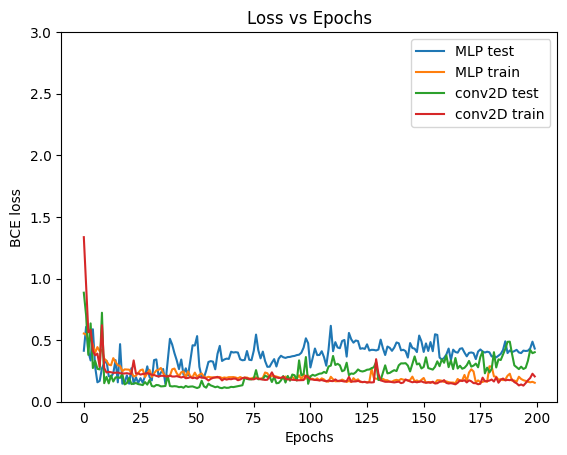

In [47]:
plt.plot(loss_stats['test'],label='MLP test')
plt.plot(loss_stats['train'],label='MLP train')
plt.plot(loss_stats_test['test'],label='conv2D test')
plt.plot(loss_stats_test['train'],label='conv2D train')
plt.legend(loc="best")
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BCE loss')
plt.ylim(0,3)

Convolutional looks better, less overfitting, but it also not look perfect and the final loss is not really good. Could be not enough epochs for train. There are wiggles in test seem like that there is overfitting also there. REuslts change every fot slightly. 

Now I do some other algorithms with standard settings. First xgboost. 

In [162]:
xc1=XGBClassifier(max_depth=6,reg_lambda=0.01).fit(feature_train,target_train)

Now predicting the results and getting the confusing matrixes. 

In [163]:
train_pred=xc1.predict(feature_train)
test_pred=xc1.predict(feature_test)
train_pred_prob=xc1.predict_proba(feature_train)
test_pred_prob=xc1.predict_proba(feature_test)
conf_train = confusion_matrix(target_train, train_pred)
conf_test = confusion_matrix(target_test, test_pred)
print("confusion matrix xgboost train")
print(conf_train)
print("confusion matrix xgboost test")
print(conf_test)

confusion matrix xgboost train
[[1468    0]
 [   0 2213]]
confusion matrix xgboost test
[[577  32]
 [ 40 929]]


Does not look so bad. 

Now logistic regression 

In [164]:
#2000 in train 91 56,  test 65 45  not converged warning
#now converged same numbers
lc1=LogisticRegression(max_iter=3000).fit(feature_train,target_train)

In [165]:
l_train_pred=lc1.predict(feature_train)
l_test_pred=lc1.predict(feature_test)
l_train_pred_prob=lc1.predict_proba(feature_train)
l_test_pred_prob=lc1.predict_proba(feature_test)
l_conf_train = confusion_matrix(target_train, l_train_pred)
l_conf_test = confusion_matrix(target_test, l_test_pred)
print("confusion matrix logistic regression train")
print(l_conf_train)
print("confusion matrix logistic regression test")
print(l_conf_test)

confusion matrix logistic regression train
[[1377   91]
 [  56 2157]]
confusion matrix logistic regression test
[[544  65]
 [ 45 924]]


Also not so bad. However, both not perfect, thus possible that neural network is better. 

Now prediction for neural network. 

In [166]:
c_test=pred_torch(model2,test_im_loader)
c_train=pred_torch(model2,train_im_loader_pred)

Define function to get confusion matrix. 

In [53]:
def conf_for_torch(predict,target):
    #round prediction
    round_pred=np.round(np.array(predict))
    conf_matrix = confusion_matrix(target, round_pred)
    return conf_matrix

In [54]:
conf_test_m=conf_for_torch(m_test,target_test)
conf_train_m=conf_for_torch(m_train,target_train)
print("3 layer perceptron")
print("train")
print(conf_train_m)
print("test")
print(conf_test_m)

3 layer perceptron
train
[[1407   61]
 [  17 2196]]
test
[[569  40]
 [ 24 945]]


Percitron seems better than xgboost. 

Now convoltional network. 

In [55]:
conf_test_c=conf_for_torch(c_test,target_test)
conf_train_c=conf_for_torch(c_train,target_train)
print("2 conv2D layers conv2D one other")
print("train")
print(conf_train_c)
print("test")
print(conf_test_c)

2 conv2D layers conv2D one other
train
[[1432   36]
 [  19 2194]]
test
[[578  31]
 [ 27 942]]


Both look similar good. Now calculating f1-scores for all. 

In [56]:
print("F1-scores")
print(f"Logistic train {np.round(f1_score(target_train,l_train_pred),5)}")
print(f"Logistic test {np.round(f1_score(target_test,l_test_pred),5)}")
print(f"xgboost train {np.round(f1_score(target_train,train_pred),5)}")
print(f"xgboost test {np.round(f1_score(target_test,test_pred),5)}")
print(f"perceptron train {np.round(f1_score(target_train,np.round(m_train)),5)}")
print(f"perceptron test {np.round(f1_score(target_test,np.round(m_test)),5)}")
print(f"conv2d train {np.round(f1_score(target_train,np.round(c_train)),5)}")
print(f"conv2d test {np.round(f1_score(target_test,np.round(c_test)),5)}")

F1-scores
Logistic train 0.96705
Logistic test 0.94382
xgboost train 1.0
xgboost test 0.96438
perceptron train 0.98255
perceptron test 0.96725
conv2d train 0.98762
conv2d test 0.97013


Train not perfect for the neural networks. Perceptron is slightly betterab than conv2d and xgbooost but differences are small.


Now conv 2d with regularization. 

In [108]:
keep_prob=1
model3 =CNNBinary3()
model3.to(device)
print(model3)

CNNBinary3(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


/tmp/ipykernel_5645/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


In [109]:
loss_stats_test3 = {
    'train': [], 'test': []
}
torch_fit(model3,train_im_loader,test_im_loader,200,64,0.001,loss_stats_test3,l2reg=0.0001)

Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.53058 | Test Loss: 1.29594
Epoch 002: | Train Loss: 1.45753 | Test Loss: 0.58563
Epoch 003: | Train Loss: 0.64985 | Test Loss: 0.69133
Epoch 004: | Train Loss: 0.63661 | Test Loss: 0.47336
Epoch 005: | Train Loss: 0.59025 | Test Loss: 0.34084
Epoch 006: | Train Loss: 0.44271 | Test Loss: 0.19064
Epoch 007: | Train Loss: 0.58084 | Test Loss: 0.48716
Epoch 008: | Train Loss: 0.42997 | Test Loss: 0.32654
Epoch 009: | Train Loss: 0.28476 | Test Loss: 0.20604
Epoch 010: | Train Loss: 0.25826 | Test Loss: 0.32135
Epoch 011: | Train Loss: 0.27947 | Test Loss: 0.20360
Epoch 012: | Train Loss: 0.31369 | Test Loss: 0.19787
Epoch 013: | Train Loss: 0.27843 | Test Loss: 0.19868
Epoch 014: | Train Loss: 0.23288 | Test Loss: 0.19888
Epoch 015: | Train Loss: 0.27354 | Test Loss: 0.21208
Epoch 016: | Train Loss: 0.27472 | Test Loss: 0.19213
Epoch 017: | Train Loss: 0.23633 | Test Loss: 0.19640
Epoch 018: | Train Loss: 0.23391 | Test Loss: 0.18751
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.15922 | Test Loss: 0.15061
Epoch 154: | Train Loss: 0.20951 | Test Loss: 0.20942
Epoch 155: | Train Loss: 0.18904 | Test Loss: 0.16802
Epoch 156: | Train Loss: 0.17639 | Test Loss: 0.14201
Epoch 157: | Train Loss: 0.14869 | Test Loss: 0.15142
Epoch 158: | Train Loss: 0.13854 | Test Loss: 0.16353
Epoch 159: | Train Loss: 0.14634 | Test Loss: 0.23563
Epoch 160: | Train Loss: 0.16675 | Test Loss: 0.23243
Epoch 161: | Train Loss: 0.18121 | Test Loss: 0.24781
Epoch 162: | Train Loss: 0.17602 | Test Loss: 0.15673
Epoch 163: | Train Loss: 0.16308 | Test Loss: 0.21416
Epoch 164: | Train Loss: 0.17178 | Test Loss: 0.22517
Epoch 165: | Train Loss: 0.17403 | Test Loss: 0.23261
Epoch 166: | Train Loss: 0.15948 | Test Loss: 0.22793
Epoch 167: | Train Loss: 0.15982 | Test Loss: 0.23050
Epoch 168: | Train Loss: 0.15168 | Test Loss: 0.22310
Epoch 169: | Train Loss: 0.14379 | Test Loss: 0.22002
Epoch 170: | Train Loss: 0.15150 | Test Loss: 0.22393
Epoch 171: | Train Loss: 0.1

(0.0, 0.7)

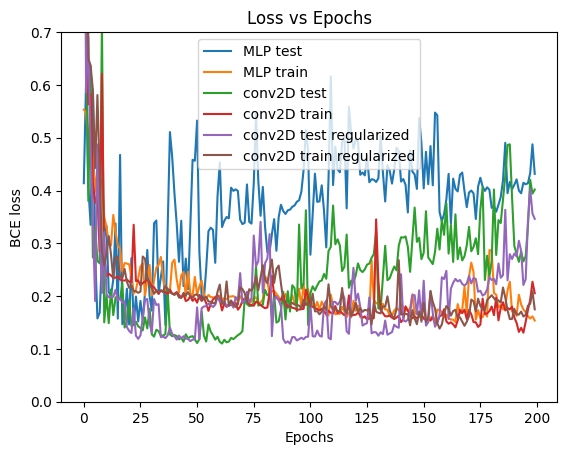

In [110]:
plt.plot(loss_stats['test'],label='MLP test')
plt.plot(loss_stats['train'],label='MLP train')
plt.plot(loss_stats_test['test'],label='conv2D test')
plt.plot(loss_stats_test['train'],label='conv2D train')
plt.plot(loss_stats_test3['test'],label='conv2D test regularized')
plt.plot(loss_stats_test3['train'],label='conv2D train regularized')
plt.legend(loc="best")
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BCE loss')
plt.ylim(0,0.7)
#1e-4 is not stable 
#0.1 looks clearly different 

In [111]:
c2_test=pred_torch(model3,test_im_loader)
c2_train=pred_torch(model3,train_im_loader_pred)
conf_test_c2=conf_for_torch(c2_test,target_test)
conf_train_c2=conf_for_torch(c2_train,target_train)
print("2 conv2D layers conv2D one other l2 regularized")
print("train")
print(conf_train_c2)
print("test")
print(conf_test_c2)

2 conv2D layers conv2D one other l2 regularized
train
[[1420   48]
 [  26 2187]]
test
[[575  34]
 [ 31 938]]


In [112]:
#0.1 train .96728 , test  0.96814 some variation with ransom ness
# 1 has train 0.9599 , test 0.9579
#0.3 train 0.96572, test 0.96758
#0.03 train  0.97216  test  0.9702
#0.01 train 0.97635  test 0.97491
#0.003 train  0.9764 test  0.97584
#0.001 train 0.97744 test 0.97744
#0.0001 train 0.98336 test 0.96651
print("F1-scores")
print(f"Logistic train {np.round(f1_score(target_train,l_train_pred),5)}")
print(f"Logistic test {np.round(f1_score(target_test,l_test_pred),5)}")
print(f"xgboost train {np.round(f1_score(target_train,train_pred),5)}")
print(f"xgboost test {np.round(f1_score(target_test,test_pred),5)}")
print(f"perceptron train {np.round(f1_score(target_train,np.round(m_train)),5)}")
print(f"perceptron test {np.round(f1_score(target_test,np.round(m_test)),5)}")
print(f"conv2d train {np.round(f1_score(target_train,np.round(c_train)),5)}")
print(f"conv2d test {np.round(f1_score(target_test,np.round(c_test)),5)}")
print(f"conv2d  regularized train {np.round(f1_score(target_train,np.round(c2_train)),5)}")
print(f"conv2d regularized test {np.round(f1_score(target_test,np.round(c2_test)),5)}")

F1-scores
Logistic train 0.96705
Logistic test 0.94382
xgboost train 1.0
xgboost test 0.96438
perceptron train 0.98255
perceptron test 0.96725
conv2d train 0.98762
conv2d test 0.97013
conv2d  regularized train 0.98336
conv2d regularized test 0.96651


In [ ]:
Now also looking on log losses.

In [113]:
#0.001 train 0.12594 test xx
#0.0001 train 0.18472 test 0.22196
print("Log lossses")
print(f"Logistic train {np.round(log_loss(target_train,l_train_pred_prob),5)}")
print(f"Logistic test {np.round(log_loss(target_test,l_test_pred_prob),5)}")
print(f"xgboost train {np.round(log_loss(target_train,train_pred_prob),5)}")
print(f"xgboost test {np.round(log_loss(target_test,test_pred_prob),5)}")
print(f"perceptron  train {np.round(log_loss(target_train,(m_train)),5)}")
print(f"perceptron test {np.round(log_loss(target_test,(m_test)),5)}")
print(f"conv2d  train {np.round(log_loss(target_train,(c_train)),5)}")
print(f"conv2d test {np.round(log_loss(target_test,(c_test)),5)}")
print(f"conv2d  regularized train {np.round(log_loss(target_train,(c2_train)),5)}")
print(f"conv2d regularized test {np.round(log_loss(target_test,(c2_test)),5)}")

Log lossses
Logistic train 0.16291
Logistic test 0.31908
xgboost train 0.00384
xgboost test 0.1591
perceptron  train 0.10428
perceptron test 0.2578
conv2d  train 0.09945
conv2d test 0.26479
conv2d  regularized train 0.11068
conv2d regularized test 0.22196


For l2 of 0.1, looks now slightly better, similar in test and train from the f1 score. Still can be chance. And not better than perceptron. Regularization of 1 is too much, is less good f1 score then. ). For 0.3 is better in test but still worse than without regularization. Exploring now several options, there seems to be a best option  at some regularziation even although randomness also influences the results. 

Now I define a function to execute several l2 regularization of the same model after each other

In [143]:
#loop on regularization 
#model used, train set, test set, train set for predict, train_target, test_target
#epochs, batch?size, alpha of fit, list of regularization, optional number of features needed for perceptron 
def run_loop_torch(model,train,test,train_for_pred,train_target,test_target,epochs,batch,alpha,regs,num_features=0):
    stats=np.zeros((5,len(regs)))
    for i in range(len(regs)):
        print(f"running reg of {regs[i]}")
        keep_prob=1
        if num_features==0:
            model3 =model()
        else:
            #num_features partlz needed
            model3 =model(num_features)            
        model3.to(device)
        loss_stats_test3 = {
        'train': [], 'test': []
        }
        torch_fit(model3,train,test,epochs,batch,alpha,loss_stats_test3,l2reg=regs[i])
        test_pred=pred_torch(model3,test)
        train_pred=pred_torch(model3,train_for_pred)
        stats[0,i]=regs[i]
        stats[1,i]=f1_score(train_target,np.round(train_pred))
        stats[2,i]=f1_score(test_target,np.round(test_pred))
        stats[3,i]=log_loss(train_target,(train_pred))
        stats[4,i]=log_loss(test_target,(test_pred))   
        print(f"stats of l2reg of  {regs[i]} are {np.round(stats[1:5,i],5)}")
    print(f"full stats are {np.round(stats[:,:].T,5)}")
    return stats

 I run it for several regularization. I choose 200 epochs that convergence is possible when no overfitting occurs. With overfitting is will still change but since the aim here is to find the regularization which has not that problem, it is not a problem. 

In [132]:
regs=[0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1]
conv2d_stats=run_loop_torch(CNNBinary3,train_im_loader,test_im_loader,train_im_loader_pred,target_train,target_test,200,64,0.001,regs)
np.savetxt("conv2d_reg1_200.txt",conv2d_stats)

running reg of 0.0001
Begin training.


/tmp/ipykernel_5645/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 36.50097 | Test Loss: 1.04130
Epoch 002: | Train Loss: 1.06799 | Test Loss: 0.42896
Epoch 003: | Train Loss: 0.56745 | Test Loss: 0.35861
Epoch 004: | Train Loss: 0.56371 | Test Loss: 0.42919
Epoch 005: | Train Loss: 0.79768 | Test Loss: 0.61663
Epoch 006: | Train Loss: 0.37301 | Test Loss: 0.33608
Epoch 007: | Train Loss: 0.29716 | Test Loss: 0.32962
Epoch 008: | Train Loss: 0.28412 | Test Loss: 0.33245
Epoch 009: | Train Loss: 0.28855 | Test Loss: 0.32672
Epoch 010: | Train Loss: 0.25929 | Test Loss: 0.32781
Epoch 011: | Train Loss: 0.25165 | Test Loss: 0.35853
Epoch 012: | Train Loss: 0.28441 | Test Loss: 0.31899
Epoch 013: | Train Loss: 0.25690 | Test Loss: 0.32006
Epoch 014: | Train Loss: 0.25630 | Test Loss: 0.33077
Epoch 015: | Train Loss: 0.26788 | Test Loss: 0.38304
Epoch 016: | Train Loss: 0.25462 | Test Loss: 0.32067
Epoch 017: | Train Loss: 0.28308 | Test Loss: 0.31778
Epoch 018: | Train Loss: 0.28144 | Test Loss: 0.38384
Epoch 019: | Train Loss: 0.

Epoch 153: | Train Loss: 0.16835 | Test Loss: 0.29563
Epoch 154: | Train Loss: 0.23420 | Test Loss: 0.27092
Epoch 155: | Train Loss: 0.17666 | Test Loss: 0.20821
Epoch 156: | Train Loss: 0.16972 | Test Loss: 0.22085
Epoch 157: | Train Loss: 0.16690 | Test Loss: 0.22610
Epoch 158: | Train Loss: 0.16771 | Test Loss: 0.21947
Epoch 159: | Train Loss: 0.15874 | Test Loss: 0.21689
Epoch 160: | Train Loss: 0.38374 | Test Loss: 0.60261
Epoch 161: | Train Loss: 0.56219 | Test Loss: 0.26613
Epoch 162: | Train Loss: 0.17911 | Test Loss: 0.20503
Epoch 163: | Train Loss: 0.15872 | Test Loss: 0.20726
Epoch 164: | Train Loss: 0.16871 | Test Loss: 0.21020
Epoch 165: | Train Loss: 0.15759 | Test Loss: 0.19719
Epoch 166: | Train Loss: 0.15641 | Test Loss: 0.20192
Epoch 167: | Train Loss: 0.15254 | Test Loss: 0.20268
Epoch 168: | Train Loss: 0.16917 | Test Loss: 0.22749
Epoch 169: | Train Loss: 0.15700 | Test Loss: 0.25826
Epoch 170: | Train Loss: 0.15200 | Test Loss: 0.23247
Epoch 171: | Train Loss: 0.1

/tmp/ipykernel_5645/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.46149 | Test Loss: 2.51046
Epoch 002: | Train Loss: 0.70615 | Test Loss: 0.49994
Epoch 003: | Train Loss: 0.61121 | Test Loss: 0.73284
Epoch 004: | Train Loss: 2.42711 | Test Loss: 0.60658
Epoch 005: | Train Loss: 0.69264 | Test Loss: 0.51153
Epoch 006: | Train Loss: 0.62010 | Test Loss: 0.47827
Epoch 007: | Train Loss: 0.55032 | Test Loss: 0.28783
Epoch 008: | Train Loss: 0.50497 | Test Loss: 0.27654
Epoch 009: | Train Loss: 0.91283 | Test Loss: 0.41954
Epoch 010: | Train Loss: 0.51805 | Test Loss: 0.28245
Epoch 011: | Train Loss: 0.41320 | Test Loss: 0.20099
Epoch 012: | Train Loss: 0.37926 | Test Loss: 0.19917
Epoch 013: | Train Loss: 0.30856 | Test Loss: 0.33432
Epoch 014: | Train Loss: 0.32843 | Test Loss: 0.19521
Epoch 015: | Train Loss: 0.27477 | Test Loss: 0.24873
Epoch 016: | Train Loss: 0.29689 | Test Loss: 0.15743
Epoch 017: | Train Loss: 0.25263 | Test Loss: 0.20234
Epoch 018: | Train Loss: 0.27628 | Test Loss: 0.31892
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.20121 | Test Loss: 0.20862
Epoch 154: | Train Loss: 0.16538 | Test Loss: 0.21641
Epoch 155: | Train Loss: 0.16564 | Test Loss: 0.23204
Epoch 156: | Train Loss: 0.15180 | Test Loss: 0.23378
Epoch 157: | Train Loss: 0.15921 | Test Loss: 0.26679
Epoch 158: | Train Loss: 0.19943 | Test Loss: 0.22405
Epoch 159: | Train Loss: 0.17376 | Test Loss: 0.21236
Epoch 160: | Train Loss: 0.15618 | Test Loss: 0.22629
Epoch 161: | Train Loss: 0.16889 | Test Loss: 0.22111
Epoch 162: | Train Loss: 0.14770 | Test Loss: 0.21044
Epoch 163: | Train Loss: 0.17798 | Test Loss: 0.20770
Epoch 164: | Train Loss: 0.17593 | Test Loss: 0.24521
Epoch 165: | Train Loss: 0.15814 | Test Loss: 0.21752
Epoch 166: | Train Loss: 0.15784 | Test Loss: 0.20522
Epoch 167: | Train Loss: 0.15539 | Test Loss: 0.23174
Epoch 168: | Train Loss: 0.15589 | Test Loss: 0.22793
Epoch 169: | Train Loss: 0.14925 | Test Loss: 0.22550
Epoch 170: | Train Loss: 0.17305 | Test Loss: 0.24288
Epoch 171: | Train Loss: 0.1

/tmp/ipykernel_5645/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 5.13658 | Test Loss: 0.82304
Epoch 002: | Train Loss: 0.52242 | Test Loss: 0.35737
Epoch 003: | Train Loss: 0.56360 | Test Loss: 2.08745
Epoch 004: | Train Loss: 1.46292 | Test Loss: 0.47350
Epoch 005: | Train Loss: 0.53485 | Test Loss: 0.35491
Epoch 006: | Train Loss: 0.45749 | Test Loss: 0.32453
Epoch 007: | Train Loss: 0.41911 | Test Loss: 0.31243
Epoch 008: | Train Loss: 0.48015 | Test Loss: 0.61715
Epoch 009: | Train Loss: 0.48570 | Test Loss: 0.32540
Epoch 010: | Train Loss: 0.39511 | Test Loss: 0.31483
Epoch 011: | Train Loss: 0.39691 | Test Loss: 0.32807
Epoch 012: | Train Loss: 0.31677 | Test Loss: 0.31213
Epoch 013: | Train Loss: 0.34288 | Test Loss: 0.26025
Epoch 014: | Train Loss: 0.34829 | Test Loss: 0.24674
Epoch 015: | Train Loss: 0.28787 | Test Loss: 0.24825
Epoch 016: | Train Loss: 0.27268 | Test Loss: 0.24821
Epoch 017: | Train Loss: 0.26668 | Test Loss: 0.25136
Epoch 018: | Train Loss: 0.24800 | Test Loss: 0.21577
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.21952 | Test Loss: 0.17982
Epoch 154: | Train Loss: 0.19025 | Test Loss: 0.25695
Epoch 155: | Train Loss: 0.18462 | Test Loss: 0.19440
Epoch 156: | Train Loss: 0.17662 | Test Loss: 0.25513
Epoch 157: | Train Loss: 0.18915 | Test Loss: 0.26929
Epoch 158: | Train Loss: 0.18813 | Test Loss: 0.18249
Epoch 159: | Train Loss: 0.28435 | Test Loss: 0.22376
Epoch 160: | Train Loss: 0.22472 | Test Loss: 0.19859
Epoch 161: | Train Loss: 0.24316 | Test Loss: 0.13249
Epoch 162: | Train Loss: 0.21870 | Test Loss: 0.13480
Epoch 163: | Train Loss: 0.20445 | Test Loss: 0.12842
Epoch 164: | Train Loss: 0.19798 | Test Loss: 0.12744
Epoch 165: | Train Loss: 0.18422 | Test Loss: 0.19604
Epoch 166: | Train Loss: 0.18577 | Test Loss: 0.20675
Epoch 167: | Train Loss: 0.19277 | Test Loss: 0.19133
Epoch 168: | Train Loss: 0.21231 | Test Loss: 0.20901
Epoch 169: | Train Loss: 0.20467 | Test Loss: 0.20266
Epoch 170: | Train Loss: 0.19073 | Test Loss: 0.21431
Epoch 171: | Train Loss: 0.1

/tmp/ipykernel_5645/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 2.51079 | Test Loss: 0.54222
Epoch 002: | Train Loss: 0.72433 | Test Loss: 0.39121
Epoch 003: | Train Loss: 0.52447 | Test Loss: 0.33804
Epoch 004: | Train Loss: 0.36532 | Test Loss: 0.38331
Epoch 005: | Train Loss: 0.47802 | Test Loss: 0.57814
Epoch 006: | Train Loss: 0.61905 | Test Loss: 0.32101
Epoch 007: | Train Loss: 0.28474 | Test Loss: 0.26082
Epoch 008: | Train Loss: 0.28149 | Test Loss: 0.25795
Epoch 009: | Train Loss: 0.28173 | Test Loss: 0.25743
Epoch 010: | Train Loss: 0.27829 | Test Loss: 0.25343
Epoch 011: | Train Loss: 0.27481 | Test Loss: 0.25415
Epoch 012: | Train Loss: 0.27644 | Test Loss: 0.25418
Epoch 013: | Train Loss: 0.27606 | Test Loss: 0.25361
Epoch 014: | Train Loss: 0.26345 | Test Loss: 0.25842
Epoch 015: | Train Loss: 0.27976 | Test Loss: 0.25447
Epoch 016: | Train Loss: 0.29679 | Test Loss: 0.26008
Epoch 017: | Train Loss: 0.25792 | Test Loss: 0.25585
Epoch 018: | Train Loss: 0.28400 | Test Loss: 0.25283
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.17796 | Test Loss: 0.24003
Epoch 154: | Train Loss: 0.18066 | Test Loss: 0.24112
Epoch 155: | Train Loss: 0.18811 | Test Loss: 0.18246
Epoch 156: | Train Loss: 0.17685 | Test Loss: 0.23879
Epoch 157: | Train Loss: 0.18101 | Test Loss: 0.24184
Epoch 158: | Train Loss: 0.18981 | Test Loss: 0.23507
Epoch 159: | Train Loss: 0.18271 | Test Loss: 0.24061
Epoch 160: | Train Loss: 0.18082 | Test Loss: 0.23744
Epoch 161: | Train Loss: 0.19400 | Test Loss: 0.24293
Epoch 162: | Train Loss: 0.19214 | Test Loss: 0.24515
Epoch 163: | Train Loss: 0.17586 | Test Loss: 0.24036
Epoch 164: | Train Loss: 0.17449 | Test Loss: 0.19347
Epoch 165: | Train Loss: 0.22227 | Test Loss: 0.23659
Epoch 166: | Train Loss: 0.22056 | Test Loss: 0.24911
Epoch 167: | Train Loss: 0.18279 | Test Loss: 0.24135
Epoch 168: | Train Loss: 0.17717 | Test Loss: 0.23455
Epoch 169: | Train Loss: 0.17713 | Test Loss: 0.19297
Epoch 170: | Train Loss: 0.19211 | Test Loss: 0.23481
Epoch 171: | Train Loss: 0.1

/tmp/ipykernel_5645/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 3.36873 | Test Loss: 1.23151
Epoch 002: | Train Loss: 1.24375 | Test Loss: 0.52306
Epoch 003: | Train Loss: 0.69884 | Test Loss: 0.34387
Epoch 004: | Train Loss: 0.48292 | Test Loss: 0.21024
Epoch 005: | Train Loss: 0.44247 | Test Loss: 0.21048
Epoch 006: | Train Loss: 0.41744 | Test Loss: 0.22879
Epoch 007: | Train Loss: 0.35793 | Test Loss: 0.24142
Epoch 008: | Train Loss: 0.47325 | Test Loss: 0.20161
Epoch 009: | Train Loss: 0.32488 | Test Loss: 0.27411
Epoch 010: | Train Loss: 0.31144 | Test Loss: 0.19878
Epoch 011: | Train Loss: 0.60550 | Test Loss: 0.19966
Epoch 012: | Train Loss: 0.27754 | Test Loss: 0.19602
Epoch 013: | Train Loss: 0.29270 | Test Loss: 0.18737
Epoch 014: | Train Loss: 0.27190 | Test Loss: 0.19324
Epoch 015: | Train Loss: 0.27233 | Test Loss: 0.18556
Epoch 016: | Train Loss: 0.27240 | Test Loss: 0.25713
Epoch 017: | Train Loss: 0.29852 | Test Loss: 0.19073
Epoch 018: | Train Loss: 0.29523 | Test Loss: 0.24745
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.21158 | Test Loss: 0.30764
Epoch 154: | Train Loss: 0.23619 | Test Loss: 0.25251
Epoch 155: | Train Loss: 0.23627 | Test Loss: 0.26223
Epoch 156: | Train Loss: 0.20607 | Test Loss: 0.31071
Epoch 157: | Train Loss: 0.20240 | Test Loss: 0.31490
Epoch 158: | Train Loss: 0.23420 | Test Loss: 0.20335
Epoch 159: | Train Loss: 0.20721 | Test Loss: 0.25822
Epoch 160: | Train Loss: 0.23425 | Test Loss: 0.31764
Epoch 161: | Train Loss: 0.22393 | Test Loss: 0.45150
Epoch 162: | Train Loss: 0.24649 | Test Loss: 0.31277
Epoch 163: | Train Loss: 0.23373 | Test Loss: 0.14257
Epoch 164: | Train Loss: 0.20020 | Test Loss: 0.25648
Epoch 165: | Train Loss: 0.20501 | Test Loss: 0.25358
Epoch 166: | Train Loss: 0.20423 | Test Loss: 0.44079
Epoch 167: | Train Loss: 0.20724 | Test Loss: 0.38067
Epoch 168: | Train Loss: 0.23263 | Test Loss: 0.30758
Epoch 169: | Train Loss: 0.20632 | Test Loss: 0.32349
Epoch 170: | Train Loss: 0.20611 | Test Loss: 0.25351
Epoch 171: | Train Loss: 0.2

/tmp/ipykernel_5645/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.89593 | Test Loss: 0.73461
Epoch 002: | Train Loss: 0.56384 | Test Loss: 1.05303
Epoch 003: | Train Loss: 0.59861 | Test Loss: 0.37131
Epoch 004: | Train Loss: 0.48309 | Test Loss: 0.39590
Epoch 005: | Train Loss: 0.51520 | Test Loss: 0.62986
Epoch 006: | Train Loss: 0.39063 | Test Loss: 0.37443
Epoch 007: | Train Loss: 0.42085 | Test Loss: 0.38619
Epoch 008: | Train Loss: 0.31490 | Test Loss: 0.72970
Epoch 009: | Train Loss: 0.37724 | Test Loss: 0.38594
Epoch 010: | Train Loss: 0.30369 | Test Loss: 0.39150
Epoch 011: | Train Loss: 0.29206 | Test Loss: 0.44231
Epoch 012: | Train Loss: 0.29081 | Test Loss: 0.44185
Epoch 013: | Train Loss: 0.29066 | Test Loss: 0.33881
Epoch 014: | Train Loss: 0.34424 | Test Loss: 0.38261
Epoch 015: | Train Loss: 0.34128 | Test Loss: 0.38637
Epoch 016: | Train Loss: 0.30773 | Test Loss: 0.38778
Epoch 017: | Train Loss: 0.32308 | Test Loss: 0.53591
Epoch 018: | Train Loss: 0.36329 | Test Loss: 0.28454
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.26155 | Test Loss: 0.32000
Epoch 154: | Train Loss: 0.26045 | Test Loss: 0.31672
Epoch 155: | Train Loss: 0.26311 | Test Loss: 0.31848
Epoch 156: | Train Loss: 0.28170 | Test Loss: 0.31585
Epoch 157: | Train Loss: 0.26185 | Test Loss: 0.31599
Epoch 158: | Train Loss: 0.27973 | Test Loss: 0.31542
Epoch 159: | Train Loss: 0.27775 | Test Loss: 0.26670
Epoch 160: | Train Loss: 0.28866 | Test Loss: 0.25574
Epoch 161: | Train Loss: 0.28706 | Test Loss: 0.32138
Epoch 162: | Train Loss: 0.31079 | Test Loss: 0.31622
Epoch 163: | Train Loss: 0.28038 | Test Loss: 0.35904
Epoch 164: | Train Loss: 0.25260 | Test Loss: 0.32391
Epoch 165: | Train Loss: 0.29108 | Test Loss: 0.32005
Epoch 166: | Train Loss: 0.31649 | Test Loss: 0.26605
Epoch 167: | Train Loss: 0.28051 | Test Loss: 0.32086
Epoch 168: | Train Loss: 0.30310 | Test Loss: 0.25723
Epoch 169: | Train Loss: 0.28273 | Test Loss: 0.31738
Epoch 170: | Train Loss: 0.23244 | Test Loss: 0.31945
Epoch 171: | Train Loss: 0.2

/tmp/ipykernel_5645/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.96168 | Test Loss: 0.53999
Epoch 002: | Train Loss: 0.48959 | Test Loss: 0.45030
Epoch 003: | Train Loss: 0.71952 | Test Loss: 0.32987
Epoch 004: | Train Loss: 0.93582 | Test Loss: 1.11653
Epoch 005: | Train Loss: 0.42210 | Test Loss: 0.46671
Epoch 006: | Train Loss: 0.31544 | Test Loss: 0.36427
Epoch 007: | Train Loss: 0.32884 | Test Loss: 0.46248
Epoch 008: | Train Loss: 0.33906 | Test Loss: 0.45367
Epoch 009: | Train Loss: 0.32803 | Test Loss: 0.46073
Epoch 010: | Train Loss: 0.29410 | Test Loss: 0.38991
Epoch 011: | Train Loss: 0.37345 | Test Loss: 0.33495
Epoch 012: | Train Loss: 0.32458 | Test Loss: 0.44897
Epoch 013: | Train Loss: 0.34610 | Test Loss: 0.39506
Epoch 014: | Train Loss: 0.27627 | Test Loss: 0.45488
Epoch 015: | Train Loss: 0.32353 | Test Loss: 0.45259
Epoch 016: | Train Loss: 0.32301 | Test Loss: 0.36692
Epoch 017: | Train Loss: 0.28520 | Test Loss: 0.30224
Epoch 018: | Train Loss: 0.29857 | Test Loss: 0.45313
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.26997 | Test Loss: 0.52331
Epoch 154: | Train Loss: 0.28371 | Test Loss: 0.75766
Epoch 155: | Train Loss: 0.26031 | Test Loss: 0.53293
Epoch 156: | Train Loss: 0.28725 | Test Loss: 0.60285
Epoch 157: | Train Loss: 0.32761 | Test Loss: 0.57381
Epoch 158: | Train Loss: 0.34716 | Test Loss: 0.52668
Epoch 159: | Train Loss: 0.26676 | Test Loss: 0.53202
Epoch 160: | Train Loss: 0.28619 | Test Loss: 0.47100
Epoch 161: | Train Loss: 0.26585 | Test Loss: 0.46821
Epoch 162: | Train Loss: 0.27598 | Test Loss: 0.46942
Epoch 163: | Train Loss: 0.34690 | Test Loss: 0.52103
Epoch 164: | Train Loss: 0.26536 | Test Loss: 0.46715
Epoch 165: | Train Loss: 0.27632 | Test Loss: 0.60465
Epoch 166: | Train Loss: 0.29164 | Test Loss: 0.51895
Epoch 167: | Train Loss: 1.10518 | Test Loss: 0.59044
Epoch 168: | Train Loss: 0.28078 | Test Loss: 0.41216
Epoch 169: | Train Loss: 0.28519 | Test Loss: 0.60268
Epoch 170: | Train Loss: 0.25436 | Test Loss: 0.60190
Epoch 171: | Train Loss: 0.3

/tmp/ipykernel_5645/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.02535 | Test Loss: 1.09528
Epoch 002: | Train Loss: 0.82415 | Test Loss: 0.57451
Epoch 003: | Train Loss: 0.65640 | Test Loss: 0.53250
Epoch 004: | Train Loss: 1.38852 | Test Loss: 0.76389
Epoch 005: | Train Loss: 0.39768 | Test Loss: 0.83383
Epoch 006: | Train Loss: 0.42208 | Test Loss: 0.47709
Epoch 007: | Train Loss: 0.38270 | Test Loss: 0.66501
Epoch 008: | Train Loss: 0.44465 | Test Loss: 0.53770
Epoch 009: | Train Loss: 0.35414 | Test Loss: 0.39997
Epoch 010: | Train Loss: 0.35361 | Test Loss: 0.41066
Epoch 011: | Train Loss: 0.37622 | Test Loss: 0.30318
Epoch 012: | Train Loss: 0.36621 | Test Loss: 0.41263
Epoch 013: | Train Loss: 0.33160 | Test Loss: 0.41359
Epoch 014: | Train Loss: 0.33453 | Test Loss: 0.39747
Epoch 015: | Train Loss: 0.36036 | Test Loss: 0.48095
Epoch 016: | Train Loss: 0.38169 | Test Loss: 0.42083
Epoch 017: | Train Loss: 0.37608 | Test Loss: 0.42081
Epoch 018: | Train Loss: 0.36959 | Test Loss: 0.35250
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.33826 | Test Loss: 0.55617
Epoch 154: | Train Loss: 0.34569 | Test Loss: 0.50131
Epoch 155: | Train Loss: 0.41456 | Test Loss: 0.50774
Epoch 156: | Train Loss: 0.34608 | Test Loss: 0.48960
Epoch 157: | Train Loss: 0.36497 | Test Loss: 0.54904
Epoch 158: | Train Loss: 0.34403 | Test Loss: 0.54920
Epoch 159: | Train Loss: 0.44948 | Test Loss: 0.62306
Epoch 160: | Train Loss: 0.42701 | Test Loss: 0.49134
Epoch 161: | Train Loss: 0.36397 | Test Loss: 0.50055
Epoch 162: | Train Loss: 0.37982 | Test Loss: 0.48990
Epoch 163: | Train Loss: 0.36673 | Test Loss: 0.54368
Epoch 164: | Train Loss: 0.34225 | Test Loss: 0.49105
Epoch 165: | Train Loss: 0.36304 | Test Loss: 0.54770
Epoch 166: | Train Loss: 0.33976 | Test Loss: 0.54930
Epoch 167: | Train Loss: 0.34323 | Test Loss: 0.54849
Epoch 168: | Train Loss: 0.37385 | Test Loss: 0.50246
Epoch 169: | Train Loss: 0.35144 | Test Loss: 0.49707
Epoch 170: | Train Loss: 0.35102 | Test Loss: 0.49318
Epoch 171: | Train Loss: 0.3

/tmp/ipykernel_5645/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.01265 | Test Loss: 0.31916
Epoch 002: | Train Loss: 0.51927 | Test Loss: 0.48177
Epoch 003: | Train Loss: 0.30495 | Test Loss: 0.37677
Epoch 004: | Train Loss: 0.31750 | Test Loss: 0.40285
Epoch 005: | Train Loss: 0.43172 | Test Loss: 0.75081
Epoch 006: | Train Loss: 0.33588 | Test Loss: 0.49038
Epoch 007: | Train Loss: 0.34643 | Test Loss: 0.46670
Epoch 008: | Train Loss: 0.32610 | Test Loss: 0.52620
Epoch 009: | Train Loss: 0.32709 | Test Loss: 0.55868
Epoch 010: | Train Loss: 0.35601 | Test Loss: 0.52522
Epoch 011: | Train Loss: 0.40039 | Test Loss: 0.48692
Epoch 012: | Train Loss: 0.35197 | Test Loss: 0.64884
Epoch 013: | Train Loss: 0.35307 | Test Loss: 0.72946
Epoch 014: | Train Loss: 0.34836 | Test Loss: 0.49848
Epoch 015: | Train Loss: 0.36948 | Test Loss: 0.53926
Epoch 016: | Train Loss: 0.35283 | Test Loss: 0.78180
Epoch 017: | Train Loss: 0.36945 | Test Loss: 0.66363
Epoch 018: | Train Loss: 0.35941 | Test Loss: 0.59599
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.38201 | Test Loss: 0.62134
Epoch 154: | Train Loss: 0.39381 | Test Loss: 0.61337
Epoch 155: | Train Loss: 0.39116 | Test Loss: 0.56588
Epoch 156: | Train Loss: 0.38589 | Test Loss: 0.61662
Epoch 157: | Train Loss: 0.38437 | Test Loss: 0.62402
Epoch 158: | Train Loss: 0.38164 | Test Loss: 0.62708
Epoch 159: | Train Loss: 0.37480 | Test Loss: 0.61196
Epoch 160: | Train Loss: 0.38030 | Test Loss: 0.61549
Epoch 161: | Train Loss: 0.37697 | Test Loss: 0.56666
Epoch 162: | Train Loss: 0.38421 | Test Loss: 0.57557
Epoch 163: | Train Loss: 0.38924 | Test Loss: 0.61149
Epoch 164: | Train Loss: 0.39520 | Test Loss: 0.74874
Epoch 165: | Train Loss: 0.40959 | Test Loss: 0.56445
Epoch 166: | Train Loss: 0.38069 | Test Loss: 0.65132
Epoch 167: | Train Loss: 0.37086 | Test Loss: 0.57040
Epoch 168: | Train Loss: 0.37544 | Test Loss: 0.61881
Epoch 169: | Train Loss: 0.38358 | Test Loss: 0.57684
Epoch 170: | Train Loss: 0.41388 | Test Loss: 0.62553
Epoch 171: | Train Loss: 0.3

Now running also the multi layer perceptron with diffrent regularizations.

In [149]:
regs=[0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1]
per_stats=run_loop_torch(BinaryClassification3,train_loader,test_loader,train_loader_pred,target_train,target_test,200,64,0.001,regs,num_features=121)
np.savetxt("per_reg1_200.txt",per_stats)

running reg of 0.0001
Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.51580 | Test Loss: 0.58172
Epoch 002: | Train Loss: 0.41055 | Test Loss: 0.57807
Epoch 003: | Train Loss: 0.46571 | Test Loss: 0.26962
Epoch 004: | Train Loss: 0.46468 | Test Loss: 0.20371
Epoch 005: | Train Loss: 0.39030 | Test Loss: 0.21433
Epoch 006: | Train Loss: 0.41512 | Test Loss: 0.15704
Epoch 007: | Train Loss: 0.43283 | Test Loss: 0.71300
Epoch 008: | Train Loss: 0.35157 | Test Loss: 0.20670
Epoch 009: | Train Loss: 0.37215 | Test Loss: 0.32275
Epoch 010: | Train Loss: 0.42153 | Test Loss: 0.38884
Epoch 011: | Train Loss: 0.40580 | Test Loss: 0.24152
Epoch 012: | Train Loss: 0.34407 | Test Loss: 0.19871
Epoch 013: | Train Loss: 0.30152 | Test Loss: 0.16583
Epoch 014: | Train Loss: 0.31595 | Test Loss: 0.28449
Epoch 015: | Train Loss: 0.29335 | Test Loss: 0.14922
Epoch 016: | Train Loss: 0.30722 | Test Loss: 0.23552
Epoch 017: | Train Loss: 0.29134 | Test Loss: 0.27000
Epoch 018: | Train Loss: 0.26571 | Test Loss: 0.16846
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.13603 | Test Loss: 0.29463
Epoch 154: | Train Loss: 0.13308 | Test Loss: 0.28513
Epoch 155: | Train Loss: 0.13111 | Test Loss: 0.29579
Epoch 156: | Train Loss: 0.14163 | Test Loss: 0.30417
Epoch 157: | Train Loss: 0.14393 | Test Loss: 0.30209
Epoch 158: | Train Loss: 0.13267 | Test Loss: 0.29493
Epoch 159: | Train Loss: 0.12827 | Test Loss: 0.29743
Epoch 160: | Train Loss: 0.13595 | Test Loss: 0.30038
Epoch 161: | Train Loss: 0.12894 | Test Loss: 0.30650
Epoch 162: | Train Loss: 0.14657 | Test Loss: 0.36210
Epoch 163: | Train Loss: 0.15951 | Test Loss: 0.34446
Epoch 164: | Train Loss: 0.11353 | Test Loss: 0.28913
Epoch 165: | Train Loss: 0.13548 | Test Loss: 0.30737
Epoch 166: | Train Loss: 0.13379 | Test Loss: 0.29610
Epoch 167: | Train Loss: 0.13302 | Test Loss: 0.29422
Epoch 168: | Train Loss: 0.10627 | Test Loss: 0.30773
Epoch 169: | Train Loss: 0.11081 | Test Loss: 0.29337
Epoch 170: | Train Loss: 0.10542 | Test Loss: 0.29921
Epoch 171: | Train Loss: 0.1

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.48244 | Test Loss: 0.48834
Epoch 002: | Train Loss: 0.41840 | Test Loss: 0.34188
Epoch 003: | Train Loss: 0.39618 | Test Loss: 0.28388
Epoch 004: | Train Loss: 0.34561 | Test Loss: 0.38996
Epoch 005: | Train Loss: 0.32204 | Test Loss: 0.16918
Epoch 006: | Train Loss: 0.35061 | Test Loss: 0.14646
Epoch 007: | Train Loss: 0.29772 | Test Loss: 0.38155
Epoch 008: | Train Loss: 0.35022 | Test Loss: 0.21887
Epoch 009: | Train Loss: 0.32845 | Test Loss: 0.33219
Epoch 010: | Train Loss: 0.30539 | Test Loss: 0.21113
Epoch 011: | Train Loss: 0.26008 | Test Loss: 0.20121
Epoch 012: | Train Loss: 0.32042 | Test Loss: 0.20750
Epoch 013: | Train Loss: 0.27257 | Test Loss: 0.20621
Epoch 014: | Train Loss: 0.26253 | Test Loss: 0.48077
Epoch 015: | Train Loss: 0.25992 | Test Loss: 0.26393
Epoch 016: | Train Loss: 0.25502 | Test Loss: 0.26052
Epoch 017: | Train Loss: 0.29203 | Test Loss: 0.25988
Epoch 018: | Train Loss: 0.29126 | Test Loss: 0.27798
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.19363 | Test Loss: 0.37263
Epoch 154: | Train Loss: 0.17420 | Test Loss: 0.32084
Epoch 155: | Train Loss: 0.17812 | Test Loss: 0.37779
Epoch 156: | Train Loss: 0.16868 | Test Loss: 0.27401
Epoch 157: | Train Loss: 0.15525 | Test Loss: 0.21378
Epoch 158: | Train Loss: 0.15593 | Test Loss: 0.25020
Epoch 159: | Train Loss: 0.16845 | Test Loss: 0.26822
Epoch 160: | Train Loss: 0.15804 | Test Loss: 0.40793
Epoch 161: | Train Loss: 0.19196 | Test Loss: 0.34097
Epoch 162: | Train Loss: 0.17363 | Test Loss: 0.21137
Epoch 163: | Train Loss: 0.18311 | Test Loss: 0.27646
Epoch 164: | Train Loss: 0.17495 | Test Loss: 0.34900
Epoch 165: | Train Loss: 0.17873 | Test Loss: 0.33527
Epoch 166: | Train Loss: 0.16762 | Test Loss: 0.36000
Epoch 167: | Train Loss: 0.15513 | Test Loss: 0.40723
Epoch 168: | Train Loss: 0.14389 | Test Loss: 0.36521
Epoch 169: | Train Loss: 0.16742 | Test Loss: 0.42347
Epoch 170: | Train Loss: 0.16810 | Test Loss: 0.41732
Epoch 171: | Train Loss: 0.1

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.52979 | Test Loss: 0.35388
Epoch 002: | Train Loss: 0.35622 | Test Loss: 0.45974
Epoch 003: | Train Loss: 0.33686 | Test Loss: 0.24936
Epoch 004: | Train Loss: 0.35948 | Test Loss: 0.15011
Epoch 005: | Train Loss: 0.35759 | Test Loss: 0.40045
Epoch 006: | Train Loss: 0.30908 | Test Loss: 0.35243
Epoch 007: | Train Loss: 0.35079 | Test Loss: 0.20244
Epoch 008: | Train Loss: 0.34506 | Test Loss: 0.34370
Epoch 009: | Train Loss: 0.31327 | Test Loss: 0.32969
Epoch 010: | Train Loss: 0.34927 | Test Loss: 0.12960
Epoch 011: | Train Loss: 0.31517 | Test Loss: 0.20495
Epoch 012: | Train Loss: 0.29381 | Test Loss: 0.12326
Epoch 013: | Train Loss: 0.28646 | Test Loss: 0.12536
Epoch 014: | Train Loss: 0.24115 | Test Loss: 0.19486
Epoch 015: | Train Loss: 0.28727 | Test Loss: 0.12763
Epoch 016: | Train Loss: 0.28910 | Test Loss: 0.12578
Epoch 017: | Train Loss: 0.23208 | Test Loss: 0.12567
Epoch 018: | Train Loss: 0.23400 | Test Loss: 0.12757
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.18414 | Test Loss: 0.22138
Epoch 154: | Train Loss: 0.18897 | Test Loss: 0.15648
Epoch 155: | Train Loss: 0.18724 | Test Loss: 0.14906
Epoch 156: | Train Loss: 0.18854 | Test Loss: 0.16616
Epoch 157: | Train Loss: 0.19000 | Test Loss: 0.14239
Epoch 158: | Train Loss: 0.18485 | Test Loss: 0.14288
Epoch 159: | Train Loss: 0.20777 | Test Loss: 0.18293
Epoch 160: | Train Loss: 0.17434 | Test Loss: 0.14570
Epoch 161: | Train Loss: 0.18301 | Test Loss: 0.15222
Epoch 162: | Train Loss: 0.15815 | Test Loss: 0.13692
Epoch 163: | Train Loss: 0.16038 | Test Loss: 0.15423
Epoch 164: | Train Loss: 0.17444 | Test Loss: 0.15899
Epoch 165: | Train Loss: 0.17602 | Test Loss: 0.16052
Epoch 166: | Train Loss: 0.17443 | Test Loss: 0.15354
Epoch 167: | Train Loss: 0.17324 | Test Loss: 0.16880
Epoch 168: | Train Loss: 0.17595 | Test Loss: 0.15590
Epoch 169: | Train Loss: 0.17894 | Test Loss: 0.21279
Epoch 170: | Train Loss: 0.17832 | Test Loss: 0.15872
Epoch 171: | Train Loss: 0.1

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.56505 | Test Loss: 0.48333
Epoch 002: | Train Loss: 0.62505 | Test Loss: 0.42788
Epoch 003: | Train Loss: 0.49850 | Test Loss: 0.45526
Epoch 004: | Train Loss: 0.50942 | Test Loss: 0.33080
Epoch 005: | Train Loss: 0.46925 | Test Loss: 0.46309
Epoch 006: | Train Loss: 0.44044 | Test Loss: 0.21924
Epoch 007: | Train Loss: 0.49162 | Test Loss: 0.52890
Epoch 008: | Train Loss: 0.44924 | Test Loss: 0.26269
Epoch 009: | Train Loss: 0.45883 | Test Loss: 0.20979
Epoch 010: | Train Loss: 0.41497 | Test Loss: 0.26503
Epoch 011: | Train Loss: 0.41498 | Test Loss: 0.20494
Epoch 012: | Train Loss: 0.40997 | Test Loss: 0.32868
Epoch 013: | Train Loss: 0.37706 | Test Loss: 0.21242
Epoch 014: | Train Loss: 0.37405 | Test Loss: 0.14640
Epoch 015: | Train Loss: 0.33751 | Test Loss: 0.26415
Epoch 016: | Train Loss: 0.31992 | Test Loss: 0.49568
Epoch 017: | Train Loss: 0.32153 | Test Loss: 0.21551
Epoch 018: | Train Loss: 0.33894 | Test Loss: 0.47039
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.19786 | Test Loss: 0.30799
Epoch 154: | Train Loss: 0.19368 | Test Loss: 0.43886
Epoch 155: | Train Loss: 0.19360 | Test Loss: 0.44018
Epoch 156: | Train Loss: 0.19318 | Test Loss: 0.32712
Epoch 157: | Train Loss: 0.28633 | Test Loss: 0.44532
Epoch 158: | Train Loss: 0.21265 | Test Loss: 0.43849
Epoch 159: | Train Loss: 0.20594 | Test Loss: 0.38249
Epoch 160: | Train Loss: 0.21532 | Test Loss: 0.26447
Epoch 161: | Train Loss: 0.20219 | Test Loss: 0.43364
Epoch 162: | Train Loss: 0.21172 | Test Loss: 0.19874
Epoch 163: | Train Loss: 0.20675 | Test Loss: 0.18748
Epoch 164: | Train Loss: 0.20482 | Test Loss: 0.18905
Epoch 165: | Train Loss: 0.20583 | Test Loss: 0.25416
Epoch 166: | Train Loss: 0.20820 | Test Loss: 0.19563
Epoch 167: | Train Loss: 0.20248 | Test Loss: 0.24981
Epoch 168: | Train Loss: 0.20178 | Test Loss: 0.37829
Epoch 169: | Train Loss: 0.20154 | Test Loss: 0.25700
Epoch 170: | Train Loss: 0.20164 | Test Loss: 0.31066
Epoch 171: | Train Loss: 0.1

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.00724 | Test Loss: 0.98371
Epoch 002: | Train Loss: 0.69747 | Test Loss: 0.86662
Epoch 003: | Train Loss: 0.59761 | Test Loss: 0.75215
Epoch 004: | Train Loss: 0.50151 | Test Loss: 0.66196
Epoch 005: | Train Loss: 0.43828 | Test Loss: 0.45965
Epoch 006: | Train Loss: 0.48621 | Test Loss: 0.49553
Epoch 007: | Train Loss: 0.42784 | Test Loss: 0.46830
Epoch 008: | Train Loss: 0.34329 | Test Loss: 0.48240
Epoch 009: | Train Loss: 0.35433 | Test Loss: 0.34617
Epoch 010: | Train Loss: 0.42947 | Test Loss: 0.40505
Epoch 011: | Train Loss: 0.32014 | Test Loss: 0.33397
Epoch 012: | Train Loss: 0.28726 | Test Loss: 0.23533
Epoch 013: | Train Loss: 0.28151 | Test Loss: 0.21220
Epoch 014: | Train Loss: 0.30556 | Test Loss: 0.39078
Epoch 015: | Train Loss: 0.30152 | Test Loss: 0.20090
Epoch 016: | Train Loss: 0.38869 | Test Loss: 0.27944
Epoch 017: | Train Loss: 0.28601 | Test Loss: 0.32763
Epoch 018: | Train Loss: 0.30888 | Test Loss: 0.25855
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.23187 | Test Loss: 0.44516
Epoch 154: | Train Loss: 0.25534 | Test Loss: 0.20992
Epoch 155: | Train Loss: 0.23496 | Test Loss: 0.39300
Epoch 156: | Train Loss: 0.22690 | Test Loss: 0.57672
Epoch 157: | Train Loss: 0.25092 | Test Loss: 0.33177
Epoch 158: | Train Loss: 0.23057 | Test Loss: 0.32578
Epoch 159: | Train Loss: 0.26938 | Test Loss: 0.19844
Epoch 160: | Train Loss: 0.25497 | Test Loss: 0.32371
Epoch 161: | Train Loss: 0.29040 | Test Loss: 0.37600
Epoch 162: | Train Loss: 0.24261 | Test Loss: 0.24841
Epoch 163: | Train Loss: 0.23849 | Test Loss: 0.22073
Epoch 164: | Train Loss: 0.22453 | Test Loss: 0.38054
Epoch 165: | Train Loss: 0.26314 | Test Loss: 0.19081
Epoch 166: | Train Loss: 0.27259 | Test Loss: 0.13498
Epoch 167: | Train Loss: 0.23907 | Test Loss: 0.14201
Epoch 168: | Train Loss: 0.24179 | Test Loss: 0.21022
Epoch 169: | Train Loss: 0.22663 | Test Loss: 0.19073
Epoch 170: | Train Loss: 0.25387 | Test Loss: 0.14259
Epoch 171: | Train Loss: 0.2

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.48651 | Test Loss: 0.18682
Epoch 002: | Train Loss: 0.36798 | Test Loss: 0.58770
Epoch 003: | Train Loss: 0.42125 | Test Loss: 0.39835
Epoch 004: | Train Loss: 0.39372 | Test Loss: 0.50524
Epoch 005: | Train Loss: 0.40700 | Test Loss: 0.32797
Epoch 006: | Train Loss: 0.39057 | Test Loss: 0.28647
Epoch 007: | Train Loss: 0.29678 | Test Loss: 0.45895
Epoch 008: | Train Loss: 0.35229 | Test Loss: 0.45899
Epoch 009: | Train Loss: 0.36074 | Test Loss: 0.38940
Epoch 010: | Train Loss: 0.38053 | Test Loss: 0.25409
Epoch 011: | Train Loss: 0.32748 | Test Loss: 0.25237
Epoch 012: | Train Loss: 0.24588 | Test Loss: 0.13965
Epoch 013: | Train Loss: 0.31594 | Test Loss: 0.20990
Epoch 014: | Train Loss: 0.29799 | Test Loss: 0.45398
Epoch 015: | Train Loss: 0.31190 | Test Loss: 0.14602
Epoch 016: | Train Loss: 0.31387 | Test Loss: 0.14184
Epoch 017: | Train Loss: 0.30481 | Test Loss: 0.23112
Epoch 018: | Train Loss: 0.26213 | Test Loss: 0.27370
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.26565 | Test Loss: 0.45516
Epoch 154: | Train Loss: 0.30305 | Test Loss: 0.26733
Epoch 155: | Train Loss: 0.26003 | Test Loss: 0.26377
Epoch 156: | Train Loss: 0.24327 | Test Loss: 0.15643
Epoch 157: | Train Loss: 0.27228 | Test Loss: 0.20234
Epoch 158: | Train Loss: 0.27704 | Test Loss: 0.31992
Epoch 159: | Train Loss: 0.23879 | Test Loss: 0.37624
Epoch 160: | Train Loss: 0.26627 | Test Loss: 0.31816
Epoch 161: | Train Loss: 0.25708 | Test Loss: 0.38884
Epoch 162: | Train Loss: 0.28296 | Test Loss: 0.33085
Epoch 163: | Train Loss: 0.26262 | Test Loss: 0.40389
Epoch 164: | Train Loss: 0.23996 | Test Loss: 0.40157
Epoch 165: | Train Loss: 0.25697 | Test Loss: 0.43909
Epoch 166: | Train Loss: 0.28778 | Test Loss: 0.19447
Epoch 167: | Train Loss: 0.30271 | Test Loss: 0.31989
Epoch 168: | Train Loss: 0.30489 | Test Loss: 0.51204
Epoch 169: | Train Loss: 0.26554 | Test Loss: 0.25793
Epoch 170: | Train Loss: 0.28429 | Test Loss: 0.26147
Epoch 171: | Train Loss: 0.2

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.95213 | Test Loss: 0.82539
Epoch 002: | Train Loss: 0.63251 | Test Loss: 0.78408
Epoch 003: | Train Loss: 0.62995 | Test Loss: 0.75790
Epoch 004: | Train Loss: 0.60841 | Test Loss: 0.78694
Epoch 005: | Train Loss: 0.60928 | Test Loss: 0.76356
Epoch 006: | Train Loss: 0.57050 | Test Loss: 0.75236
Epoch 007: | Train Loss: 0.56290 | Test Loss: 0.78150
Epoch 008: | Train Loss: 0.61177 | Test Loss: 0.85773
Epoch 009: | Train Loss: 0.59832 | Test Loss: 0.76013
Epoch 010: | Train Loss: 0.62941 | Test Loss: 0.69878
Epoch 011: | Train Loss: 0.52587 | Test Loss: 0.55950
Epoch 012: | Train Loss: 0.54335 | Test Loss: 0.58056
Epoch 013: | Train Loss: 0.48919 | Test Loss: 0.65445
Epoch 014: | Train Loss: 0.50431 | Test Loss: 0.65105
Epoch 015: | Train Loss: 0.48267 | Test Loss: 0.67951
Epoch 016: | Train Loss: 0.37165 | Test Loss: 0.89396
Epoch 017: | Train Loss: 0.38884 | Test Loss: 0.68945
Epoch 018: | Train Loss: 0.39376 | Test Loss: 0.67651
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.31305 | Test Loss: 0.52369
Epoch 154: | Train Loss: 0.35906 | Test Loss: 0.48320
Epoch 155: | Train Loss: 0.31161 | Test Loss: 0.58759
Epoch 156: | Train Loss: 0.30910 | Test Loss: 0.59124
Epoch 157: | Train Loss: 0.31617 | Test Loss: 0.52389
Epoch 158: | Train Loss: 0.39715 | Test Loss: 0.58546
Epoch 159: | Train Loss: 0.34190 | Test Loss: 0.54606
Epoch 160: | Train Loss: 0.31005 | Test Loss: 0.52706
Epoch 161: | Train Loss: 0.30762 | Test Loss: 0.46028
Epoch 162: | Train Loss: 0.31104 | Test Loss: 0.60368
Epoch 163: | Train Loss: 0.32865 | Test Loss: 0.41433
Epoch 164: | Train Loss: 0.28888 | Test Loss: 0.60753
Epoch 165: | Train Loss: 0.31337 | Test Loss: 0.58714
Epoch 166: | Train Loss: 0.33569 | Test Loss: 0.59140
Epoch 167: | Train Loss: 0.33192 | Test Loss: 0.52855
Epoch 168: | Train Loss: 0.30738 | Test Loss: 0.70375
Epoch 169: | Train Loss: 0.29368 | Test Loss: 0.52236
Epoch 170: | Train Loss: 0.29931 | Test Loss: 0.57546
Epoch 171: | Train Loss: 0.3

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.55020 | Test Loss: 0.61517
Epoch 002: | Train Loss: 0.42281 | Test Loss: 0.80486
Epoch 003: | Train Loss: 0.38955 | Test Loss: 0.60715
Epoch 004: | Train Loss: 0.49157 | Test Loss: 0.57156
Epoch 005: | Train Loss: 1.22564 | Test Loss: 0.69926
Epoch 006: | Train Loss: 0.41346 | Test Loss: 0.55747
Epoch 007: | Train Loss: 0.41837 | Test Loss: 0.57089
Epoch 008: | Train Loss: 0.42201 | Test Loss: 0.71861
Epoch 009: | Train Loss: 0.41999 | Test Loss: 0.70110
Epoch 010: | Train Loss: 0.37980 | Test Loss: 0.48849
Epoch 011: | Train Loss: 0.36444 | Test Loss: 0.62497
Epoch 012: | Train Loss: 0.43757 | Test Loss: 0.71348
Epoch 013: | Train Loss: 0.39964 | Test Loss: 0.50689
Epoch 014: | Train Loss: 0.34110 | Test Loss: 0.61305
Epoch 015: | Train Loss: 0.30828 | Test Loss: 0.74633
Epoch 016: | Train Loss: 0.35538 | Test Loss: 0.56565
Epoch 017: | Train Loss: 0.31254 | Test Loss: 0.72076
Epoch 018: | Train Loss: 0.30929 | Test Loss: 0.74214
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.29113 | Test Loss: 0.61678
Epoch 154: | Train Loss: 0.28550 | Test Loss: 0.69451
Epoch 155: | Train Loss: 0.31007 | Test Loss: 0.61974
Epoch 156: | Train Loss: 0.28666 | Test Loss: 0.56913
Epoch 157: | Train Loss: 0.31806 | Test Loss: 0.61766
Epoch 158: | Train Loss: 0.30117 | Test Loss: 0.56337
Epoch 159: | Train Loss: 0.28136 | Test Loss: 0.62623
Epoch 160: | Train Loss: 0.30683 | Test Loss: 0.61279
Epoch 161: | Train Loss: 0.32568 | Test Loss: 0.61978
Epoch 162: | Train Loss: 0.32202 | Test Loss: 0.62562
Epoch 163: | Train Loss: 0.29638 | Test Loss: 0.62344
Epoch 164: | Train Loss: 0.30678 | Test Loss: 0.69879
Epoch 165: | Train Loss: 0.28709 | Test Loss: 0.53881
Epoch 166: | Train Loss: 0.32246 | Test Loss: 0.60763
Epoch 167: | Train Loss: 0.31148 | Test Loss: 0.61384
Epoch 168: | Train Loss: 0.30559 | Test Loss: 0.61055
Epoch 169: | Train Loss: 0.28952 | Test Loss: 0.56590
Epoch 170: | Train Loss: 0.30823 | Test Loss: 0.56293
Epoch 171: | Train Loss: 0.3

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.46722 | Test Loss: 0.56426
Epoch 002: | Train Loss: 0.36550 | Test Loss: 0.65279
Epoch 003: | Train Loss: 0.36179 | Test Loss: 0.61322
Epoch 004: | Train Loss: 0.36596 | Test Loss: 0.63521
Epoch 005: | Train Loss: 0.36829 | Test Loss: 0.53283
Epoch 006: | Train Loss: 0.35272 | Test Loss: 0.63997
Epoch 007: | Train Loss: 0.34586 | Test Loss: 0.65253
Epoch 008: | Train Loss: 0.38024 | Test Loss: 0.63546
Epoch 009: | Train Loss: 0.35558 | Test Loss: 0.69507
Epoch 010: | Train Loss: 0.35129 | Test Loss: 0.64492
Epoch 011: | Train Loss: 0.35437 | Test Loss: 0.56050
Epoch 012: | Train Loss: 0.37501 | Test Loss: 0.61883
Epoch 013: | Train Loss: 0.35754 | Test Loss: 0.63799
Epoch 014: | Train Loss: 0.35857 | Test Loss: 0.65262
Epoch 015: | Train Loss: 0.36082 | Test Loss: 0.60200
Epoch 016: | Train Loss: 0.35022 | Test Loss: 0.62011
Epoch 017: | Train Loss: 0.35687 | Test Loss: 0.64595
Epoch 018: | Train Loss: 0.36768 | Test Loss: 0.63724
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.34734 | Test Loss: 0.64573
Epoch 154: | Train Loss: 0.34638 | Test Loss: 0.64046
Epoch 155: | Train Loss: 0.34500 | Test Loss: 0.64028
Epoch 156: | Train Loss: 0.34728 | Test Loss: 0.63678
Epoch 157: | Train Loss: 0.35159 | Test Loss: 0.63445
Epoch 158: | Train Loss: 0.34348 | Test Loss: 0.64795
Epoch 159: | Train Loss: 0.34563 | Test Loss: 0.69080
Epoch 160: | Train Loss: 0.36699 | Test Loss: 0.76496
Epoch 161: | Train Loss: 0.35959 | Test Loss: 0.65238
Epoch 162: | Train Loss: 0.35537 | Test Loss: 0.76770
Epoch 163: | Train Loss: 0.34346 | Test Loss: 0.63633
Epoch 164: | Train Loss: 0.34816 | Test Loss: 0.70452
Epoch 165: | Train Loss: 0.35064 | Test Loss: 0.63162
Epoch 166: | Train Loss: 0.34088 | Test Loss: 0.63171
Epoch 167: | Train Loss: 0.34079 | Test Loss: 0.60770
Epoch 168: | Train Loss: 0.34572 | Test Loss: 0.64487
Epoch 169: | Train Loss: 0.34762 | Test Loss: 0.64640
Epoch 170: | Train Loss: 0.35246 | Test Loss: 0.75397
Epoch 171: | Train Loss: 0.3

In [ ]:
Now also adding regularization to xgboost.

In [184]:
def loop_xgboost(feature_train,target_train,feature_test,target_test,regs):
    stats=np.zeros((5,len(regs)))
    for i in range(len(regs)):
        print(f"doing l2 regularization {regs[i]}")
        xc1=XGBClassifier(max_depth=6,reg_lambda=regs[i]).fit(feature_train,target_train)
        train_pred=xc1.predict(feature_train)
        test_pred=xc1.predict(feature_test)
        train_pred_prob=xc1.predict_proba(feature_train)
        test_pred_prob=xc1.predict_proba(feature_test)
        stats[0,i]=regs[i]
        stats[1,i]=f1_score(target_train,train_pred)
        stats[2,i]=f1_score(target_test,test_pred)       
        stats[3,i]=log_loss(target_train,train_pred_prob)
        stats[4,i]=log_loss(target_test,test_pred_prob)
    return stats

In [188]:
regs=[0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,30,100,300,1000,3000,10000]
stats_xgb=loop_xgboost(feature_train,target_train,feature_test,target_test,regs)
print(stats_xgb.T)

doing l2 regularization 0.0001
doing l2 regularization 0.0003
doing l2 regularization 0.001
doing l2 regularization 0.003
doing l2 regularization 0.01
doing l2 regularization 0.03
doing l2 regularization 0.1
doing l2 regularization 0.3
doing l2 regularization 1
doing l2 regularization 3
doing l2 regularization 10
doing l2 regularization 30
doing l2 regularization 100
doing l2 regularization 300
doing l2 regularization 1000
doing l2 regularization 3000
doing l2 regularization 10000
[[1.00000000e-04 1.00000000e+00 9.64912281e-01 2.51956692e-03
  1.71278638e-01]
 [3.00000000e-04 1.00000000e+00 9.61658031e-01 2.30595113e-03
  1.59827181e-01]
 [1.00000000e-03 1.00000000e+00 9.62694301e-01 2.39115854e-03
  1.70769301e-01]
 [3.00000000e-03 1.00000000e+00 9.64839710e-01 2.40291345e-03
  1.70816850e-01]
 [1.00000000e-02 1.00000000e+00 9.62694301e-01 2.42729959e-03
  1.67822680e-01]
 [3.00000000e-02 1.00000000e+00 9.63383187e-01 2.40727017e-03
  1.69079506e-01]
 [1.00000000e-01 1.00000000e+00 9.

not regularized
Logistic train 0.96705
Logistic test 0.94382
xgboost train 1.0
xgboost test 0.96269
perceptron train 0.98255
perceptron test 0.96725
conv2d train 0.98762
conv2d test 0.97013
best regularized
perceptron train 0.98188
perceptron test 0.97245
conv2d train 0.98525
conv2d test 0.97698
xgboost train 1.0
xgboost test 0.96694


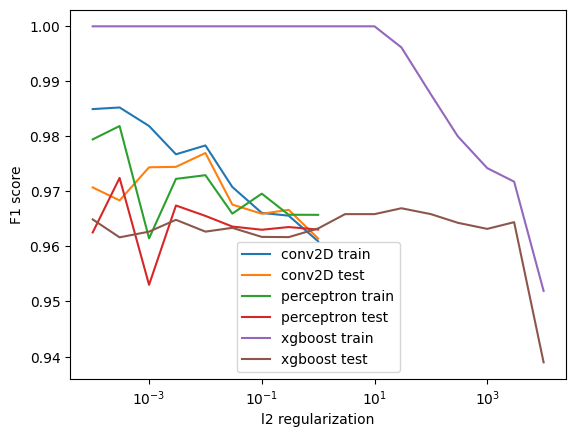

In [191]:
plt.plot(conv2d_stats[0],conv2d_stats[1],label='conv2D train')
plt.plot(conv2d_stats[0],conv2d_stats[2],label='conv2D test')
plt.plot(per_stats[0],per_stats[1],label='perceptron train')
plt.plot(per_stats[0],per_stats[2],label='perceptron test')
plt.plot(stats_xgb[0],stats_xgb[1],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[2],label='xgboost test')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('F1 score')
#plt.ylim(0,0.7)
plt.xscale("log")
print("not regularized")
print(f"Logistic train {np.round(f1_score(target_train,l_train_pred),5)}")
print(f"Logistic test {np.round(f1_score(target_test,l_test_pred),5)}")
print(f"xgboost train {np.round(f1_score(target_train,train_pred),5)}")
print(f"xgboost test {np.round(f1_score(target_test,test_pred),5)}")
print(f"perceptron train {np.round(f1_score(target_train,np.round(m_train)),5)}")
print(f"perceptron test {np.round(f1_score(target_test,np.round(m_test)),5)}")
print(f"conv2d train {np.round(f1_score(target_train,np.round(c_train)),5)}")
print(f"conv2d test {np.round(f1_score(target_test,np.round(c_test)),5)}")
print("best regularized")
print(f"perceptron train {np.round(np.max(per_stats[1]),5)}")
print(f"perceptron test {np.round(np.max(per_stats[2]),5)}")
print(f"conv2d train {np.round(np.max(conv2d_stats[1]),5)}")
print(f"conv2d test {np.round(np.max(conv2d_stats[2]),5)}")
print(f"xgboost train {np.round(np.max(stats_xgb[1]),5)}")
print(f"xgboost test {np.round(np.max(stats_xgb[2]),5)}")


Convolutional neural network looks best in f1 score, but mahcine leaerning methods are not yet optimized

not regularized
Logistic train 0.16291
Logistic test 0.31908
xgboost train 0.00243
xgboost test 0.16782
perceptron train 0.10428
perceptron test 0.2578
conv2d train 0.09945
conv2d test 0.26479
best regularized
perceptron train 0.09119
perceptron test 0.20566
conv2d train 0.09665
conv2d test 0.1438
xgboost train 0.00231
xgboost test 0.12609


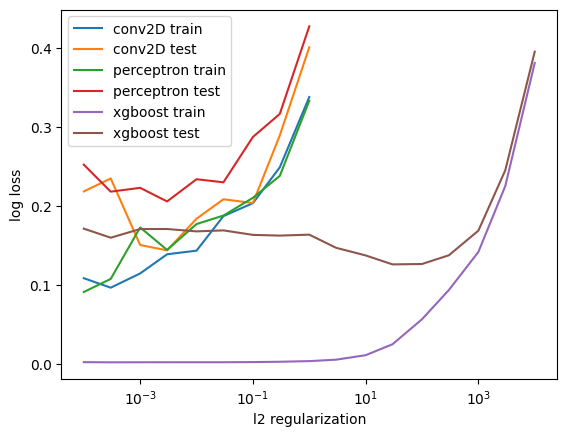

In [194]:
plt.plot(conv2d_stats[0],conv2d_stats[3],label='conv2D train')
plt.plot(conv2d_stats[0],conv2d_stats[4],label='conv2D test')
plt.plot(per_stats[0],per_stats[3],label='perceptron train')
plt.plot(per_stats[0],per_stats[4],label='perceptron test')
plt.plot(stats_xgb[0],stats_xgb[3],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[4],label='xgboost test')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('log loss')
#plt.ylim(0,0.7)
plt.xscale("log")
print("not regularized")
print(f"Logistic train {np.round(log_loss(target_train,l_train_pred_prob),5)}")
print(f"Logistic test {np.round(log_loss(target_test,l_test_pred_prob),5)}")
print(f"xgboost train {np.round(log_loss(target_train,train_pred_prob),5)}")
print(f"xgboost test {np.round(log_loss(target_test,test_pred_prob),5)}")
print(f"perceptron train {np.round(log_loss(target_train,(m_train)),5)}")
print(f"perceptron test {np.round(log_loss(target_test,(m_test)),5)}")
print(f"conv2d train {np.round(log_loss(target_train,(c_train)),5)}")
print(f"conv2d test {np.round(log_loss(target_test,(c_test)),5)}")
print("best regularized")
print(f"perceptron train {np.round(np.min(per_stats[3]),5)}")
print(f"perceptron test {np.round(np.min(per_stats[4]),5)}")
print(f"conv2d train {np.round(np.min(conv2d_stats[3]),5)}")
print(f"conv2d test {np.round(np.min(conv2d_stats[4]),5)}")
print(f"xgboost train {np.round(np.min(stats_xgb[3]),5)}")
print(f"xgboost test {np.round(np.min(stats_xgb[4]),5)}")

Looks similar here, convolutional network is also best, after regularization it is also better than xgboost unregularized, but the best regularization of xgboost is better. The best regularization depends slightkly on metric, it is 0.003 for log loss while it is 0.01 for f1 score.

I should also generate more data from the same images. Easy options are flipping and 3 rotations, that are 5, thus simple size times 6. Less clear whether adding noise works, at least needs more testing on which level is fine, it should include images which are impossible and also not too similar ones. Likely needs special splitting techniques that not too similar data is in test.  